IDEAT: Vix takas? Joku momentum indikaattori? Sentimentti?




##Model settings

In [261]:
use_regime_split = False

#Default modelsD
RF = True # perus random forest
RF2 = False
GB = False # perus gradient boost
Hybrid = False

#Looping models
RF_feature_seek = False # random forest all combinations
seek_all = False
gb_loop = False

#DATA
FF5 = False
FF5_long = False
MSCI = True

RSI = True

local = False #ajetaanko colab vai oma kone




In [262]:
# Identify active model flags
active_modes = [name for name, flag in zip(
    ['RF', 'GB', 'RF_feature_seek', 'Hybrid', 'seek_all', 'gb_loop'],
    [RF, GB, RF_feature_seek, Hybrid, seek_all, gb_loop]
) if flag]

if active_modes:
    print("✅ Active model modes:", ", ".join(active_modes))
else:
    print("⚠️ No active model mode selected.")

# Check dataset toggles: exactly one must be True
datasets = {
    'FF5': FF5,
    'FF5_long': FF5_long,
    'MSCI': MSCI
}
active_datasets = [name for name, flag in datasets.items() if flag]

if len(active_datasets) != 1:
    raise ValueError("Error: Exactly one of [FF5, FF5_long, MSCI] must be True.")
else:
    print(f"📊 Using dataset: {active_datasets[0]}")


✅ Active model modes: RF
📊 Using dataset: MSCI


In [263]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [264]:
if not local:

  %cd /content
  !rm -rf Gradu
  !git clone https://github.com/Elkkujou/Gradu.git
  %cd /content/Gradu
  !ls
  xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")

else:



    repo_url = "https://github.com/Elkkujou/Gradu.git"
    repo_name = "Gradu"  # Name of the cloned folder

    # Check if the directory already exists
    if os.path.exists(repo_name):
        print(f"Folder '{repo_name}' already exists. Pulling latest changes...")
        # Change to the existing repo folder and pull the latest updates
        subprocess.run(["git", "-C", repo_name, "pull"], check=True)
    else:
        print(f"Cloning repository into '{repo_name}'...")
        subprocess.run(["git", "clone", repo_url], check=True)

    # List contents of the cloned repository
    subprocess.run(["ls", repo_name], check=True)
    xls_file = pd.ExcelFile("Gradu/THE_2ND_latest.xlsx")



/content
Cloning into 'Gradu'...
remote: Enumerating objects: 1127, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 1127 (delta 164), reused 131 (delta 131), pack-reused 950 (from 3)
Receiving objects: 100% (1127/1127), 303.32 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (562/562), done.
/content/Gradu
 chatti_RF.ipynb		      regime_pred.txt
 data+regimes.xlsx		      RF_Gradu.ipynb
 Fama_french_XGBOOST.ipynb	      RF_REGIIMI_HYVÄ_TRAINING_2.ipynb
'Financial turbulence.ipynb'	      RF_REGIIMI_HYVÄ_TRAINING.ipynb
 FT_source.xlsx			     'RF_REGIIMI_HYVÄ_TRAINING (MSCI).ipynb'
 Gradient_boost_malli.ipynb	     'RF_regime (3).ipynb'
 MSCI_XGBOOST.ipynb		      THE_2ND_latest.xlsx
 Regiimi_prediction.ipynb	      THE_2ND.xlsx
 regime_prediction_famafrench.ipynb   THE_ONE.xlsx
 regime_prediction_msci.ipynb


In [265]:
if FF5:
  SHEET_NAME = "ajodata_FF5"
  FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'GARCH']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = False

In [266]:
if FF5_long:
  SHEET_NAME = "ajodata_FF5_long"
  FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'GARCH']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = True

In [267]:
if MSCI:
  SHEET_NAME = "ajodata_MSCI_2"
  FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'VIX']
  FACTORS = [
    'Size',
    'value',
    'Quality',
    'min_vola']
  BENCHMARK = ['Us_standard']
  show_benchmark = True

##Prepare data

In [268]:
df = xls_file.parse(SHEET_NAME)
df.columns = df.columns.get_level_values(0)

# Print headers dynamically
print(f"Headers in the '{SHEET_NAME}' sheet:")
print(df.columns)

REGIMES_COLUMN = 'Predicted_reg'

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'ajodata_MSCI_2' sheet:
Index(['Date', 'RF', 'Us_standard', 'Size', 'min_vola', 'value', 'Quality',
       'CPI%', 'T10Y3M', 'CFNAI', 'VIX'],
      dtype='object')


Description,Value
First observation date,1994-07-30 00:00:00
Last observation date,2025-04-30 00:00:00
Total number of observations,370


In [269]:
if RSI:

  # --- Add lagged 12‑month moving average for each factor return ---
  for f in FACTORS:
      # shift by 1 so that MA at time t uses returns t-12…t-1
      df[f + '_MA12'] = (
          df[f]
          .shift(1)                          # drop “today”
          .rolling(window=12, min_periods=12)
          .mean()
      )

  # update your FEATURES list
  FEATURES += [f + '_MA12' for f in FACTORS]

  print("✨ Added lagged 12‑month MA columns:", [f + '_MA12' for f in FACTORS])
  print("🧩 New FEATURES list:", FEATURES)

✨ Added lagged 12‑month MA columns: ['Size_MA12', 'value_MA12', 'Quality_MA12', 'min_vola_MA12']
🧩 New FEATURES list: ['CPI%', 'T10Y3M', 'CFNAI', 'VIX', 'Size_MA12', 'value_MA12', 'Quality_MA12', 'min_vola_MA12']


In [270]:
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# ------------------------------------------------------------
# 1.  Inputs
# ------------------------------------------------------------
# df      : DataFrame of monthly total-return series (index = month-end dates)
# FACTORS : list/tuple of column names in df you want analysed
#
# Example:
# df       = pd.read_csv("monthly_returns.csv", parse_dates=["Date"]).set_index("Date")
# FACTORS  = ["Value", "Momentum", "Quality", "LowVol"]
# ------------------------------------------------------------

# ---------- Helper functions ----------
def annualized_return(returns: pd.Series) -> float:
    """Compounded annualised return from monthly series."""
    return (1 + returns).prod() ** (12 / len(returns)) - 1

def compute_metrics(returns: pd.Series) -> tuple[float, float, float]:
    """Annualised return, annualised volatility, and cumulative return."""
    ann_ret = annualized_return(returns)
    ann_vol = returns.std() * np.sqrt(12)          # monthly → annual
    cum_ret = (1 + returns).prod() - 1
    return ann_ret, ann_vol, cum_ret

# ---------- Win-rate (highest-return months, factors only) ----------
monthly_winner = df[FACTORS].idxmax(axis=1)        # winner each month (benchmark excluded)
win_rates = (
    monthly_winner.value_counts()                  # how many wins per factor
    .reindex(FACTORS, fill_value=0) / len(df)      # re-index ensures original order
)

# ---------- Number-format helper (space as thousands separator) ----------
NBSP = "\u202F"                                    # thin non-breaking space renders well in HTML

def pct_with_space(x: float) -> str:
    """Format a decimal as percentage with 1-dp and thin-space thousands separator."""
    return f"{x * 100:,.1f}%".replace(",", NBSP)

# ---------- Build the summary table ----------
records = []
for col in FACTORS:
    r = df[col]
    ann_ret, ann_vol, cum_ret = compute_metrics(r)
    records.append({
        "Factor":                   col,
        "Annualised Return":        pct_with_space(ann_ret),
        "Annualised Volatility":    pct_with_space(ann_vol),
        "Total Cumulative Return":  pct_with_space(cum_ret),
        "Win rate":                 pct_with_space(win_rates[col]),
    })

metrics_df = pd.DataFrame(records)

# ---------- Display ----------
display(HTML(metrics_df.to_html(index=False)))

Factor,Annualised Return,Annualised Volatility,Total Cumulative Return,Win rate
Size,10.4%,16.6%,2 029.9%,28.1%
value,8.2%,15.1%,1 022.5%,16.8%
Quality,12.2%,14.7%,3 377.1%,31.1%
min_vola,9.7%,11.9%,1 644.9%,24.1%


In [271]:
# Toggle for dropping rows with missing values in the FEATURES columns.
drop_empty = True

# 1) Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# 2) Show missing‐value counts in FEATURES.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in FEATURES before cleaning:")
print(missing_counts)

# 3) Drop any rows with NA in FEATURES, if requested.
if drop_empty:
    before = len(df)
    df.dropna(subset=FEATURES, inplace=True)
    df.reset_index(drop=True, inplace=True)
    dropped = before - len(df)
    print(f"\nDropped {dropped} rows due to missing FEATURES.")
else:
    print("\nKeeping all rows, including those with missing FEATURES.")

# 4) Re‐check that FEATURES are now complete:
print("\nMissing values in FEATURES after cleaning:")
print(df[FEATURES].isna().sum())

# 5) Compute your target column in‐place.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1).astype('category')

# 6) (Optionally) create a numeric code column
df['Winning Factor Code'] = df['Winning Factor'].cat.codes

# 7) Quick summary:
print(f"\nFinal dataset now has {len(df)} rows.")
print("Target value counts:")
print(df['Winning Factor'].value_counts())

Total number of rows before cleaning: 370

Missing values in FEATURES before cleaning:
CPI%              0
T10Y3M            0
CFNAI             0
VIX               0
Size_MA12        12
value_MA12       12
Quality_MA12     12
min_vola_MA12    12
dtype: int64

Dropped 12 rows due to missing FEATURES.

Missing values in FEATURES after cleaning:
CPI%             0
T10Y3M           0
CFNAI            0
VIX              0
Size_MA12        0
value_MA12       0
Quality_MA12     0
min_vola_MA12    0
dtype: int64

Final dataset now has 358 rows.
Target value counts:
Winning Factor
Quality     108
Size        102
min_vola     87
value        61
Name: count, dtype: int64


In [272]:
if use_regime_split:

    # --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

    # Dynamically extract the unique values in the REGIMES_COLUMN.
    unique_regimes = df[REGIMES_COLUMN].unique()

    # Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
    df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

    # Create a dictionary mapping numeric codes to the regime names based on the unique values.
    regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

    # Now encode the Regimes column as numeric codes.
    df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

    # Create a mapping from numeric codes to original regime names.
    regime_short_mapping = {code: name for code, name in regime_mapping.items()}

    # Calculate the number of observations for each regime using value_counts (without reindexing).
    obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

    # Create a DataFrame preview of the regime mapping, including observation counts.
    mapping_table_data = []
    for code in regime_mapping.keys():
        mapping_table_data.append({
            "Numeric Code": code,
            "Original Name": regime_mapping.get(code, "N/A"),
            "Observations": obs_counts.get(code, 0)
        })

    # Append a row with the total observations.
    total_obs = obs_counts.sum()
    mapping_table_data.append({
        "Numeric Code": "",
        "Original Name": "Total",
        "Observations": total_obs
    })

    # Create the DataFrame for regime mapping preview and print.
    regime_mapping_df = pd.DataFrame(mapping_table_data)

    from tabulate import tabulate
    print("Preview of Dynamic Regime Mapping:")
    print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


# Models

##Feature seek

In [273]:
if RF_feature_seek:
    import itertools
    import os
    import time
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier

    # --------------------------
    # Parameters for Feature & Training Window Search
    # --------------------------
    min_features = 2                  # minimum number of features in a subset
    max_features = len(FEATURES)      # maximum number of features (or set to a smaller number if desired)

    # Define fixed rolling window sizes (in years) to test (assuming monthly data)
    training_window_years = [5, 10, 15, 20]

    # Also run an expanding window experiment
    run_expanding_window = True

    # Independent variable: minimum number of observations required for making a prediction.
    # This is now decoupled from the training window calculation.
    min_obs_for_prediction = 60  # adjust this value as desired

    output_filename = "feature_subset_results.csv"
    if os.path.exists(output_filename):
        os.remove(output_filename)

    # Ensure the data is sorted by date.
    df_sorted = df.sort_values('Date').reset_index(drop=True)

    # --------------------------
    # Outer Loop: Fixed Rolling Window Modes
    # --------------------------
    for years in training_window_years:
        # Convert years to number of observations (assume 12 obs per year)
        rolling_window_size = years * 12
        # Ensure predictions start only after both the rolling window and the independent minimum are met.
        start_index = max(min_obs_for_prediction, rolling_window_size)
        print(f"\n--- Testing fixed rolling window of {years} years "
              f"({rolling_window_size} observations, starting predictions at index {start_index}) ---")
        outer_start_time = time.time()

        # Inner loop over feature subset sizes
        for r in range(min_features, max_features + 1):
            # Loop over all combinations of size r
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination: {current_features}")
                results = []

                # Loop over test rows, starting when we have enough training data
                for i in range(start_index, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']

                    # Build fixed rolling training window (most recent rolling_window_size observations)
                    train_window = df_sorted.iloc[i - rolling_window_size : i].copy()

                    # Ensure the last training observation is strictly before test row date
                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    # (Optional) Regime check if use_regime_split is True:
                    if use_regime_split:
                        regime_counts = train_window[REGIMES_COLUMN].value_counts()
                        insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
                        if insufficient_regimes:
                            continue
                        current_regime = test_row[REGIMES_COLUMN]
                        train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
                        if len(train_window) < min_obs_regime:
                            continue

                    # Prepare training data for the current feature subset.
                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    # Train the RandomForest model.
                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    # Use the last row of the training window as test data.
                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    # Map the predicted probabilities to the full set of FACTORS.
                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    # months_ahead: how many months ahead the prediction is (optional usage)
                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    # Collect feature levels for logging
                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    # Create a result row
                    result = {
                        "TrainingWindowYears": years,   # <--- Record the training window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                # End of inner test row loop for this feature combination.
                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Results for combination {current_features} appended to CSV. "
                          f"Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed fixed rolling window of {years} years in {minutes:02d}:{seconds:02d}")

    # --------------------------
    # Expanding Window Mode
    # --------------------------
    if run_expanding_window:
        print("\n--- Testing Expanding Window Mode ---")
        outer_start_time = time.time()
        for r in range(min_features, max_features + 1):
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination (expanding): {current_features}")
                results = []

                # In expanding mode, the training window goes from the start until the test row.
                # Start predictions only after the minimum observation threshold is met.
                for i in range(min_obs_for_prediction, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']
                    train_window = df_sorted.iloc[:i].copy()
                    if train_window.empty:
                        continue

                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    result = {
                        "TrainingWindowYears": "expanding",  # <--- Indicate expanding window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Expanding window: Results for combination {current_features} "
                          f"appended to CSV. Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed Expanding Window Mode in {minutes:02d}:{seconds:02d}")


##Seek all

In [274]:
if seek_all:
  import pandas as pd
  import numpy as np
  import csv
  import itertools
  import time
  import math
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import ParameterGrid

  # ───────────────────────────────────────
  # Assumes `df` (with 'Date' & 'Winning Factor'),
  # `FACTORS` (list of all factor names) and
  # `FEATURES` (base feature list) are defined above
  # ───────────────────────────────────────

  # ───────────────────────────────────────
  # Toggle feature‑looping on/off
  # ───────────────────────────────────────
  loop_features = False   # False ⇒ single run on FEATURES; True ⇒ sweep always+optional

  # ───────────────────────────────────────
  # 1) Define always‑on & optional features
  # ───────────────────────────────────────
  always_features = [
      "CMA_MA12", "SMB_MA12", "RMW_MA12", "HML_MA12",
      "CPI%"
  ]
  optional_features = [
      "LEI%", "Cape", "Cape %", "TED",
      "T10Y3", "LEI", "AR_Shock", "HV",
      "EWMA_0.94", "T10YFF", "CFNAI", "GARCH_1M", "VIX","BAA10Y"
  ]

  # ───────────────────────────────────────
  # 1a) Control how many optional features per combo
  # ───────────────────────────────────────
  min_optional = 1   # minimum number of optional features in each combo
  max_optional = 5   # maximum number of optional features in each combo

  # ───────────────────────────────────────
  # 2) Build feature_combinations (with new constraints)
  # ───────────────────────────────────────
  volatility_features = {"GARCH_1M", "VIX", "AR_Shock", "HV", "EWMA_0.94"}
  lei_group          = {"LEI", "LEI%", "CFNAI"}
  cape_group         = {"Cape", "Cape %"}

  if loop_features:
      def valid_combo(combo):
          combo = set(combo)
          # 1) at most 2 volatility measures
          if len(combo & volatility_features) > 2:
              return False
          # 2) T10Y3 and T10YFF cannot co‑exist
          if {"T10Y3", "T10YFF"} <= combo:
              return False
          # 3) only one of LEI, LEI%, CFNAI
          if len(combo & lei_group) > 1:
              return False
          # 4) only one of Cape, Cape %
          if len(combo & cape_group) > 1:
              return False
          return True

      feature_combinations = [
          always_features + list(combo)
          for r in range(min_optional, max_optional + 1)
          for combo in itertools.combinations(optional_features, r)
          if valid_combo(combo)
      ]
  else:
      feature_combinations = [FEATURES]

  # ───────────────────────────────────────
  # 3) RF hyperparameter template (excluding max_features)
  # ───────────────────────────────────────
  param_grid_template = {
      'n_estimators':      [100, 300, 500],
      'max_depth':         [None, 7, 10, 15],
      'min_samples_split': [2, 4, 6],
      'min_samples_leaf':  [1, 3, 5, 7],
      'bootstrap':         [False, True],
      'n_jobs':            [-1]
  }
  base_param_list = list(ParameterGrid(param_grid_template))

  # compute total iterations for progress display
  total_iterations = sum(
      len(base_param_list) * len(range(2, len(feat_set) + 1, 2))
      for feat_set in feature_combinations
  )

  # ───────────────────────────────────────
  # 4) CSV logging setup
  # ───────────────────────────────────────
  csv_file = 'rf_feature_search.csv'
  fieldnames = [
      'Iteration','Training_Window','Features','Hyperparameters',
      'Num_Preds','First_Pred','Last_Pred',
      'CumAlloc_Post2000','CumEqual_Post2000',
      'CumAlloc_Total','CumEqual_Total',
      'Sharpe_Post2000','Win_Count_Post2000'
  ]
  with open(csv_file, 'w', newline='') as f:
      writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=';')
      writer.writeheader()

  # ───────────────────────────────────────
  # 5) Rolling‑window & data settings
  # ───────────────────────────────────────
  rolling_window_size = 60   # months in each fixed window
  min_months_train    = 60   # minimum months of history required
  min_obs_train       = 0    # minimum non-missing rows in X_train
  use_fixed_window    = True # True: fixed-length rolling window; False: expanding window

  # ───────────────────────────────────────
  # 6) Loop over feature sets & hyperparameters
  # ───────────────────────────────────────
  iteration = 0
  summary_records = []

  for feat_set in feature_combinations:
      n_feats = len(feat_set)
      # for n_feats = 8, this gives [2, 4, 6, 8]
      max_features_opts = list(range(2, n_feats + 1, 2))

      # inject max_features into each base parameter combination
      param_list = [
          {**p, 'max_features': mf}
          for p in base_param_list
          for mf in max_features_opts
      ]

      for rf_params in param_list:
          iteration += 1
          start_time = time.perf_counter()

          # --- print at start ---
          print(f"\n=== Iteration {iteration}/{total_iterations} ===")
          if loop_features:
              print(f"Always‑on features ({len(always_features)}): {always_features}")
              print(f"Optional count range: {min_optional}–{max_optional}")
          print(f"Using features ({n_feats}): {feat_set}")
          print(f"RF hyperparameters: {rf_params}")

          # drop rows with missing values in this feature set only
          df_iter = df.dropna(subset=feat_set).copy()
          df_sorted = df_iter.sort_values('Date').reset_index(drop=True)
          results = []

          # per‑row prediction loop
          for i in range(1, len(df_sorted)):
              test_row = df_sorted.iloc[i]

              # build training window from prior rows
              if use_fixed_window:
                  start_idx    = max(0, i - rolling_window_size)
                  train_window = df_sorted.iloc[start_idx:i].copy()
              else:
                  train_window = df_sorted.iloc[:i].copy()

              if len(train_window) < min_months_train:
                  continue

              # prepare training data
              X_train = train_window[feat_set].dropna()
              y_train = train_window['Winning Factor'].loc[X_train.index]
              if len(X_train) < min_obs_train:
                  continue

              # fit RandomForest
              rf = RandomForestClassifier(**rf_params, random_state=42)
              rf.fit(X_train, y_train)

              # predict on the last available row in train_window
              X_test = train_window[feat_set].iloc[[-1]].dropna()
              if X_test.empty:
                  continue

              probs      = rf.predict_proba(X_test)[0]
              full_probs = np.zeros(len(FACTORS))
              for cls, p in zip(rf.classes_, probs):
                  full_probs[FACTORS.index(cls)] = p

              alloc_ret = (full_probs * test_row[FACTORS].values).sum()
              eq_ret    = test_row[FACTORS].mean()

              results.append({
                  'Date': test_row['Date'],
                  'Allocated_Return': alloc_ret,
                  'Equal_Weight_Return': eq_ret
              })

          # compute summary metrics
          res_df = pd.DataFrame(results).sort_values('Date')
          if res_df.empty:
              summary = dict.fromkeys(fieldnames, np.nan)
              summary.update({
                  'Iteration': iteration,
                  'Training_Window': rolling_window_size,
                  'Features': ",".join(feat_set),
                  'Hyperparameters': ";".join(f"{k}={v}" for k,v in rf_params.items()),
                  'Num_Preds': 0
              })
          else:
              post2k        = res_df[res_df['Date'] >= pd.Timestamp("2000-01-01")]
              cum_alloc_2k  = (1 + post2k['Allocated_Return']).prod() - 1
              cum_eq_2k     = (1 + post2k['Equal_Weight_Return']).prod()  - 1
              cum_alloc_tot = (1 + res_df['Allocated_Return']).prod()     - 1
              cum_eq_tot    = (1 + res_df['Equal_Weight_Return']).prod()  - 1

              sharpe_2k = (post2k['Allocated_Return'].mean() /
                          post2k['Allocated_Return'].std()) * np.sqrt(12)
              win2k = (post2k['Allocated_Return'] > post2k['Equal_Weight_Return']).sum()

              summary = {
                  'Iteration': iteration,
                  'Training_Window': rolling_window_size,
                  'Features': ",".join(feat_set),
                  'Hyperparameters': ";".join(f"{k}={v}" for k,v in rf_params.items()),
                  'Num_Preds': len(res_df),
                  'First_Pred': res_df['Date'].iloc[0].strftime("%Y-%m-%d"),
                  'Last_Pred':  res_df['Date'].iloc[-1].strftime("%Y-%m-%d"),
                  'CumAlloc_Post2000': cum_alloc_2k,
                  'CumEqual_Post2000':  cum_eq_2k,
                  'CumAlloc_Total':      cum_alloc_tot,
                  'CumEqual_Total':       cum_eq_tot,
                  'Sharpe_Post2000':     sharpe_2k,
                  'Win_Count_Post2000':  win2k
              }

          # write one line to CSV
          with open(csv_file, 'a', newline='') as f:
              writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=';')
              writer.writerow(summary)
              f.flush()

          # update running ranks & print end summary
          summary_records.append(summary)
          df_sum = pd.DataFrame(summary_records)
          df_sum['Rank_CumAlloc_Post2000']   = df_sum['CumAlloc_Post2000'].rank(ascending=False, method='min')
          df_sum['Rank_Sharpe_Post2000']     = df_sum['Sharpe_Post2000'].rank(ascending=False, method='min')
          df_sum['Rank_CumAlloc_Total']      = df_sum['CumAlloc_Total'].rank(ascending=False, method='min')
          df_sum['Rank_Win_Count_Post2000']  = df_sum['Win_Count_Post2000'].rank(ascending=False, method='min')

          cur = df_sum.iloc[-1]
          duration = time.perf_counter() - start_time

          # print end‑of‑iteration stats
          print(f"Completed iteration {iteration}/{total_iterations} in {duration:.1f}s")
          print(f"  CumAlloc_Post2000: {cur['CumAlloc_Post2000']:.4f} (rank {int(cur['Rank_CumAlloc_Post2000'])}/{iteration})")
          print(f"  Sharpe_Post2000:   {cur['Sharpe_Post2000']:.4f} (rank {int(cur['Rank_Sharpe_Post2000'])}/{iteration})")
          print(f"  CumAlloc_Total:    {cur['CumAlloc_Total']:.4f} (rank {int(cur['Rank_CumAlloc_Total'])}/{iteration})")
          print(f"  Win_Count_Post2000:{int(cur['Win_Count_Post2000'])} (rank {int(cur['Rank_Win_Count_Post2000'])}/{iteration})")
          print(f"  EqualWeight_Post2000: {cur['CumEqual_Post2000']:.4f}")
          print(f"  EqualWeight_Total:     {cur['CumEqual_Total']:.4f}")


## Random forest

In [275]:
###############################################################################
# CELL 1 —  Random-Forest rolling training / prediction
#           (with permutation-importance snapshots)
###############################################################################
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

# ---------------------------------------------------------------------------
# Assumes these variables already exist in your notebook:
#   df, FEATURES, FACTORS, REGIMES_COLUMN, regime_short_mapping
# ---------------------------------------------------------------------------

###############################  PARAMETERS  #################################
min_months_train        = 60
min_obs_regime          = 50
min_obs_train           = 0
use_regime_split        = False
default_hyperparameters = False

use_fixed_window    = True
rolling_window_size = 60
n_jobs              = -1

compute_permutation_importance = True
compute_pdp                     = True
compute_shap                    = True
##############################################################################


############################  MODEL HYPER-PARAMS  ############################
rf_params = (
    dict(
        n_estimators      = 100,  max_depth         = None,
        max_features      = "sqrt",   min_samples_split = 2,
        min_samples_leaf  = 1,    bootstrap         = True,
        n_jobs            = n_jobs
    ) if default_hyperparameters else
    dict(
        n_estimators      = 100,  max_depth         = None,
        max_features      = None,    min_samples_split = 2,
        min_samples_leaf  = 5,    bootstrap         = False,
        n_jobs            = n_jobs
    )
)
##############################################################################


###########################  OPTIONAL CONTAINERS  ############################
if compute_pdp:
    from sklearn.inspection import partial_dependence
    pdp_data = {f: [] for f in FEATURES}

if compute_shap:
    import shap
    shap_data = []

if compute_permutation_importance:
    from sklearn.inspection import permutation_importance
    perm_importances_list: list[np.ndarray] = []
    months_list:            list[pd.Timestamp] = []
##############################################################################


#############################  TRAINING LOOP  ################################
df_sorted = df.sort_values("Date").reset_index(drop=True)
results   = []

for i in range(1, len(df_sorted) + 1):          # ← “+1” adds the next-month row
    # ── 1. build training window ────────────────────────────────────────────
    train_window = (
        df_sorted.iloc[max(0, i - rolling_window_size):i].copy()
        if use_fixed_window else
        df_sorted.iloc[:i].copy()
    )
    if len(train_window) < min_months_train:
        continue

    train_start_date = train_window["Date"].iloc[0]
    train_end_date   = train_window["Date"].iloc[-1]

    # ── 2. regime split (optional) ──────────────────────────────────────────
    if use_regime_split:
        counts = train_window[REGIMES_COLUMN].value_counts()
        if any(counts < min_obs_regime):
            continue
        current_regime = df_sorted.iloc[min(i, len(df_sorted)-1)][REGIMES_COLUMN]
        train_window   = train_window[train_window[REGIMES_COLUMN] == current_regime]
        if len(train_window) < min_obs_regime:
            continue
        regime_used = regime_short_mapping.get(current_regime, str(current_regime))
    else:
        regime_used = "NoRegime"

    # ── 3. training matrices ────────────────────────────────────────────────
    X_train = train_window[FEATURES].dropna()
    y_train = train_window.loc[X_train.index, "Winning Factor"]
    if len(X_train) < min_obs_train:
        continue

    # ── 4. fit model ────────────────────────────────────────────────────────
    rf_model = RandomForestClassifier(**rf_params, random_state=42)
    rf_model.fit(X_train, y_train)

    # ── 5. permutation importance snapshot ──────────────────────────────────
    if compute_permutation_importance and i < len(df_sorted):   # skip future row
        pi = permutation_importance(
            rf_model, X_train, y_train,
            n_repeats   = 10,
            random_state= 42,
            n_jobs      = n_jobs
        )
        perm_importances_list.append(pi.importances_mean)       # 1-D array
        months_list.append(train_end_date)                      # Timestamp

    # ── 6. decide which row to predict ──────────────────────────────────────
    future_row = (i == len(df_sorted))
    X_test_src, Predicted_month = (
        (df_sorted.iloc[[-1]],
         df_sorted["Date"].iloc[-1] + pd.offsets.MonthEnd(1))
        if future_row else
        (train_window.iloc[[-1]], df_sorted.iloc[i]["Date"])
    )
    X_test = X_test_src[FEATURES].dropna()
    if X_test.empty:
        continue

    # ── 7. SHAP snapshot (optional) ─────────────────────────────────────────
    if compute_shap:
        try:
            explainer = shap.Explainer(rf_model, X_train)
            vals      = explainer(X_test).values
        except Exception:
            explainer = shap.TreeExplainer(rf_model)
            sv_list   = explainer.shap_values(X_test)
            vals      = np.stack(sv_list, axis=-1)[0] if isinstance(sv_list, list) else sv_list
        shap_mat = vals[0].T if vals.ndim == 3 else (
                   vals.T   if vals.shape[0] == len(FEATURES) else
                   np.tile(vals, (len(FACTORS), 1)))
        shap_data.append({"month": Predicted_month,
                          "feature_vals": X_test.iloc[0].values,
                          "shap_values":  shap_mat})

    # ── 8. prediction & metrics ─────────────────────────────────────────────
    probs          = rf_model.predict_proba(X_test)[0]
    winner         = rf_model.classes_[probs.argmax()]
    full_probs     = np.zeros(len(FACTORS))
    for cls, p in zip(rf_model.classes_, probs):
        if cls in FACTORS:
            full_probs[FACTORS.index(cls)] = p

    if future_row:
        allocated_return = equal_ret = actual_winner = np.nan
        months_ahead     = 1
    else:
        test_row         = df_sorted.iloc[i]
        allocated_return = (full_probs * test_row[FACTORS].values).sum()
        equal_ret        = test_row[FACTORS].mean()
        actual_winner    = test_row["Winning Factor"]
        months_ahead     = ((Predicted_month.year  - train_end_date.year)  * 12 +
                            (Predicted_month.month - train_end_date.month))

    feat_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

    results.append({
        "Regime":                   regime_used,
        "Predicted_month":          Predicted_month,
        "Train_Start_Date":         train_start_date,
        "Train_End_Date":           train_end_date,
        "Train_Count":              len(X_train),
        "Feature_Importances":      rf_model.feature_importances_,
        "Predicted_Probabilities":  full_probs,
        "Predicted_Winner":         winner,
        "Allocated_Return":         allocated_return,
        "Equal_Weight_Return":      equal_ret,
        "Actual_Winner":            actual_winner,
        "Num_Trees":                rf_model.n_estimators,
        "Average_Tree_Depth":       np.mean([t.tree_.max_depth for t in rf_model.estimators_]),
        "Max_Tree_Depth":           np.max([t.tree_.max_depth for t in rf_model.estimators_]),
        "Prediction_Horizon_Months": months_ahead,
        **feat_levels
    })

    # ── 9. progress print ───────────────────────────────────────────────────
    print(f"Test row date: {Predicted_month.date()} -> Model trained, "
          f"prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

##########################  WRAP-UP / DISPLAY  ###############################
results_df_rf = pd.DataFrame(results)
display(results_df_rf.tail(12))
print(f"\nPermutation rows collected: {len(perm_importances_list)}")


Test row date: 2000-07-30 -> Model trained, prediction made (using: 1995-07-30 - 2000-06-30)
Test row date: 2000-08-30 -> Model trained, prediction made (using: 1995-08-30 - 2000-07-30)
Test row date: 2000-09-30 -> Model trained, prediction made (using: 1995-09-30 - 2000-08-30)
Test row date: 2000-10-30 -> Model trained, prediction made (using: 1995-10-30 - 2000-09-30)
Test row date: 2000-11-30 -> Model trained, prediction made (using: 1995-11-30 - 2000-10-30)
Test row date: 2000-12-30 -> Model trained, prediction made (using: 1995-12-30 - 2000-11-30)
Test row date: 2001-01-30 -> Model trained, prediction made (using: 1996-01-30 - 2000-12-30)
Test row date: 2001-02-28 -> Model trained, prediction made (using: 1996-02-29 - 2001-01-30)
Test row date: 2001-03-30 -> Model trained, prediction made (using: 1996-03-30 - 2001-02-28)
Test row date: 2001-04-30 -> Model trained, prediction made (using: 1996-04-30 - 2001-03-30)
Test row date: 2001-05-30 -> Model trained, prediction made (using: 19

,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10Y3M,Feature_Level_CFNAI,Feature_Level_VIX,Feature_Level_Size_MA12,Feature_Level_value_MA12,Feature_Level_Quality_MA12,Feature_Level_min_vola_MA12
287,NoRegime,2024-06-30,2019-06-30,2024-05-30,60,"[0.015220700152206995, 0.47908240921939566, 0....","[0.16666666666666646, 0.16666666666666646, 0.6...",Quality,0.026845,0.014139,...,4,1,0.29125,-0.74,-0.38,12.92,0.014470,0.011079,0.022932,0.008483
288,NoRegime,2024-07-30,2019-07-30,2024-06-30,60,"[0.17340990301174053, 0.3139816232771817, 0.0,...","[0.0, 0.19999999999999962, 0.7999999999999985,...",Quality,0.011708,0.032180,...,4,1,0.03961,-0.88,0.15,12.44,0.018430,0.016889,0.025194,0.013528
289,NoRegime,2024-08-30,2019-08-30,2024-07-30,60,"[0.13942182001005524, 0.2804072398190042, 0.0,...","[0.0, 0.2857142857142854, 0.1428571428571427, ...",min_vola,0.041094,0.034234,...,4,1,-0.00287,-1.11,-0.17,16.36,0.011940,0.011754,0.023525,0.011260
290,NoRegime,2024-09-30,2019-09-30,2024-08-30,60,"[0.13942182001005524, 0.2804072398190042, 0.0,...","[0.0, 0.2857142857142854, 0.1428571428571427, ...",min_vola,0.008412,0.012815,...,4,1,0.13892,-1.14,-0.30,15.00,0.011865,0.012768,0.020758,0.013247
291,NoRegime,2024-10-30,2019-10-30,2024-09-30,60,"[0.016117890858853283, 0.35636656688924706, 0....","[0.1428571428571427, 0.1428571428571427, 0.142...",min_vola,-0.014188,-0.013713,...,4,1,0.18019,-0.91,-0.05,16.73,0.016613,0.017264,0.023784,0.017843
292,NoRegime,2024-11-30,2019-11-30,2024-10-30,60,"[0.016849199663016012, 0.37140172380273484, 0....","[0.25, 0.125, 0.125, 0.5]",min_vola,0.056309,0.056074,...,4,1,0.22920,-0.23,-0.21,23.16,0.022298,0.021722,0.028596,0.020555
293,NoRegime,2024-12-30,2019-12-30,2024-11-30,60,"[0.24186508525982262, 0.21441514607036538, 0.3...","[0.5, 0.0, 0.16666666666666646, 0.333333333333...",Size,-0.055255,-0.055149,...,4,1,0.22646,-0.24,-0.50,13.51,0.025200,0.023123,0.028403,0.020066
294,NoRegime,2025-01-30,2020-01-30,2024-12-30,60,"[0.22701381512039243, 0.20124938775987788, 0.2...","[0.0, 0.0, 1.0, 0.0]",Quality,0.037292,0.039659,...,4,1,0.28045,0.31,-0.04,17.35,0.023379,0.021697,0.025066,0.019413
295,NoRegime,2025-02-28,2020-02-29,2025-01-30,60,"[0.24442395165546835, 0.1898115376258929, 0.24...","[0.125, 0.25, 0.125, 0.5]",min_vola,0.013404,0.003861,...,4,1,0.36467,0.37,0.37,16.43,0.011933,0.011313,0.018390,0.012503
296,NoRegime,2025-03-30,2020-03-30,2025-02-28,60,"[0.24812442817932265, 0.17367437050002, 0.2471...","[0.11111111111111088, 0.22222222222222177, 0.1...",min_vola,-0.020253,-0.032934,...,4,1,0.46694,0.02,-0.26,19.63,0.016159,0.014578,0.018892,0.013620



Permutation rows collected: 298


###RF tree visualization

In [276]:
if RF:
    # ─────────────────────────────────────────────────────────────────────────────
    # CELL: Interactive selector for prediction date & tree number
    # ─────────────────────────────────────────────────────────────────────────────
    import ipywidgets as widgets
    from IPython.display import display
    from sklearn import tree
    import matplotlib.pyplot as plt

    # build a list of the dates you predicted on
    prediction_dates = [
        res['Predicted_month'].date()
        for res in results  # or results_df_rf['Predicted_month']
    ]

    # map date → model
    model_by_date = dict(zip(prediction_dates, rf_models))

    # widget for selecting date
    date_widget = widgets.Dropdown(
        options=prediction_dates,
        description='Date:',
    )

    # widget for selecting tree index
    tree_widget = widgets.IntSlider(
        value=0,
        min=0,
        max=rf_params['n_estimators'] - 1,
        step=1,
        description='Tree #:',
    )

    def plot_tree_for_selection(chosen_date, tree_idx):
        model     = model_by_date[chosen_date]
        estimator = model.estimators_[tree_idx]

        # extra‐large figure & text for bigger boxes and labels
        plt.figure(figsize=(30, 15), dpi=300)
        tree.plot_tree(
            estimator,
            feature_names=RF1_FEATURES,
            class_names=[str(c) for c in model.classes_],
            filled=True,
            rounded=True,
            fontsize=16,         # bump this up for larger node labels
        )
        plt.axis('off')         # hide axes
        plt.tight_layout()      # remove extra padding
        plt.show()

    # wire up interactive display
    interactive_ui = widgets.interactive(
        plot_tree_for_selection,
        chosen_date=date_widget,
        tree_idx=tree_widget
    )
    display(interactive_ui)

interactive(children=(Dropdown(description='Date:', options=(datetime.date(2000, 7, 30), datetime.date(2000, 8…

In [277]:
import ipywidgets as widgets
from IPython.display import display
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib as mpl

# ─────────────────────────────────────────────────────────────────────────────
# Assumptions: you have these already in your namespace:
#   • results       — list or iterable of dicts/DataFrame rows with 'Predicted_month'
#   • rf_models     — list of fitted RandomForestClassifier/Regressor objects
#   • rf_params     — dict with at least 'n_estimators'
#   • RF1_FEATURES  — list of feature-name strings
# ─────────────────────────────────────────────────────────────────────────────

prediction_dates = [
    res['Predicted_month'].date()
    for res in results
]
model_by_date = dict(zip(prediction_dates, rf_models))

date_widget = widgets.Dropdown(options=prediction_dates, description='Date:')
tree_widget = widgets.IntSlider(
    value=0,
    min=0,
    max=rf_params['n_estimators'] - 1,
    step=1,
    description='Tree #:'
)

def plot_tree_for_selection(chosen_date, tree_idx):
    model     = model_by_date[chosen_date]
    estimator = model.estimators_[tree_idx]

    # huge canvas
    plt.figure(figsize=(40, 20), dpi=100)
    ax = plt.gca()

    # plot with big text & proportional boxes
    tree.plot_tree(
        estimator,
        feature_names=RF1_FEATURES,
        class_names=[str(c) for c in model.classes_],
        filled=True,
        rounded=True,
        proportion=True,
        fontsize=24,
        ax=ax
    )

    # pad-out each box
    for patch in ax.patches:
        if isinstance(patch, mpl.patches.FancyBboxPatch):
            patch.set_boxstyle("round,pad=1.2")

    # REMOVE any "value =" line from the node text
    for txt in ax.texts:
        lines = txt.get_text().split('\n')
        # filter out the value line
        filtered = [ln for ln in lines if not ln.strip().startswith('value')]
        txt.set_text('\n'.join(filtered))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

interactive_ui = widgets.interactive(
    plot_tree_for_selection,
    chosen_date=date_widget,
    tree_idx=tree_widget
)
display(interactive_ui)

interactive(children=(Dropdown(description='Date:', options=(datetime.date(2000, 7, 30), datetime.date(2000, 8…

##RF2

In [278]:
# Cell 2 — second RF run under RF2
if RF2:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from IPython.display import display, HTML

    # -------------------
    # RF2: Drop _MA12 and GARCH_1M
    # -------------------
    RF2_FEATURES = [f for f in FEATURES if not f.endswith('_MA12') and f != 'GARCH_1M']
    #RF2_FEATURES = [f for f in FEATURES if f not in ['Cape']]


    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train    = 60
    min_obs_regime      = 50
    min_obs_train       = 0
    use_regime_split    = False
    default_hyperparams = False

    use_fixed_window    = True
    rolling_window_size = 60

    n_jobs = -1

    # -------------------
    # Hyperparameter Settings
    # -------------------
    if default_hyperparams:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': 'sqrt',
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'bootstrap': True,
            'n_jobs': n_jobs
        }
    else:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': None,
            'min_samples_split': 2,
            'min_samples_leaf': 5,
            'bootstrap': False,
            'n_jobs': n_jobs
        }

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results_rf2 = []

    # -------------------
    # 2) Main Loop
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Skip if insufficient data or overlapping dates
        if len(train_window) < min_months_train:
            continue
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            continue

        # Prepare X_train / y_train using RF2_FEATURES
        X_train = train_window[RF2_FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            continue

        # Train RF
        rf_model = RandomForestClassifier(**rf_params, random_state=42)
        rf_model.fit(X_train, y_train)

        # Prepare X_test
        X_test = train_window[RF2_FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            continue

        # Predict and map probabilities
        probs = rf_model.predict_proba(X_test)[0]
        full_probs = np.zeros(len(FACTORS))
        for cls, p in zip(rf_model.classes_, probs):
            if cls in FACTORS:
                full_probs[FACTORS.index(cls)] = p

        # Calculate returns
        allocated_return    = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Feature levels from RF2_FEATURES
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in RF2_FEATURES}

        result = {
            'Regime': 'NoRegime',
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_window['Date'].iloc[0],
            'Train_End_Date': last_train_date,
            'Train_Count': len(X_train),
            'Feature_Importances': rf_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': rf_model.classes_[probs.argmax()],
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': np.mean([t.tree_.max_depth for t in rf_model.estimators_]),
            'Max_Tree_Depth': np.max([t.tree_.max_depth for t in rf_model.estimators_]),
            'Prediction_Horizon_Months': ((Predicted_month.year - last_train_date.year) * 12 +
                                         (Predicted_month.month - last_train_date.month)),
            **feature_levels
        }
        results_rf2.append(result)

    # -------------------
    # 3) Build RF2 results DataFrame
    # -------------------
    results_df_rf2 = pd.DataFrame(results_rf2)
    print("Final results_df_rf2 columns:", results_df_rf2.columns.tolist())
    display(results_df_rf2.tail(10))

    # -------------------
    # Cumulative returns (2000 onward & total)
    # -------------------
    filtered2 = results_df_rf2[results_df_rf2['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered2.empty:
        cum_alloc2 = (1 + filtered2['Allocated_Return']).prod() - 1
        cum_eq2    = (1 + filtered2['Equal_Weight_Return']).prod() - 1
        print(f"Cumulative 2000–present — RF2: {cum_alloc2:.4f}  /  Equal: {cum_eq2:.4f}")

    if not results_df_rf2.empty:
        cum_alloc_all2 = (1 + results_df_rf2['Allocated_Return']).prod() - 1
        cum_eq_all2    = (1 + results_df_rf2['Equal_Weight_Return']).prod() - 1
        print(f"Total cumulative — RF2: {cum_alloc_all2:.4f}  /  Equal: {cum_eq_all2:.4f}")


## Gradient boosting


In [279]:
# ── Gradient-Boost (XGBoost) rolling prediction loop ─────────────────────────
if GB:
    import pandas as pd
    import numpy as np
    from xgboost import XGBClassifier
    from IPython.display import display, HTML

    # ------------------- 1) Parameters ---------------------------------------
    min_months_train        = 60
    min_obs_regime          = 50
    min_obs_train           = 0
    use_regime_split        = False
    default_hyperparameters = False

    use_fixed_window    = True
    rolling_window_size = 60

    # ------------------- 2) Prep ---------------------------------------------
    df_sorted = df.sort_values("Date").reset_index(drop=True)
    results   = []

    # ------------------- 3) Main loop ----------------------------------------
    for i in range(1, len(df_sorted) + 1):          # one step past the end
        # -- 3A. build training window ---------------------------------------
        if use_fixed_window:
            start_idx    = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        if len(train_window) < min_months_train:
            continue

        train_start_date = train_window["Date"].iloc[0]
        train_end_date   = train_window["Date"].iloc[-1]

        # -- 3B. regime split (optional) -------------------------------------
        if use_regime_split:
            counts = train_window[REGIMES_COLUMN].value_counts()
            if any(counts < min_obs_regime):
                continue
            current_regime = df_sorted.iloc[min(i, len(df_sorted)-1)][REGIMES_COLUMN]
            train_window   = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = "NoRegime"

        # -- 3C. training matrices -------------------------------------------
        X_train = train_window[FEATURES].dropna()
        y_train = train_window.loc[X_train.index, "Winning Factor"]
        if len(X_train) < min_obs_train:
            continue

        y_cat   = y_train.astype("category")
        mapping = dict(enumerate(y_cat.cat.categories))
        y_num   = y_cat.cat.codes

        # -- 3D. hyper-parameters --------------------------------------------
        if default_hyperparameters:
            xgb_params = dict(
                n_estimators     = 100,
                max_depth        = 3,
                learning_rate    = 0.1,
                subsample        = 1.0,
                colsample_bytree = 1.0,
                random_state     = 42,
                eval_metric      = "mlogloss"
            )
        else:
            xgb_params = dict(
                n_estimators     = 200,
                max_depth        = 15,
                learning_rate    = 0.17,
                subsample        = 0.75,
                colsample_bytree = 0.5,
                min_child_weight = 7,
                random_state     = 42,
                n_jobs           = -1,
                eval_metric      = "mlogloss"
            )

        # -- 3E. fit model ----------------------------------------------------
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_num)

        # -- 3F. choose row to predict ---------------------------------------
        future_row = (i == len(df_sorted))
        if future_row:
            X_test_src      = df_sorted.iloc[[-1]]          # last real row
            Predicted_month = df_sorted["Date"].iloc[-1] + pd.offsets.MonthEnd(1)
        else:
            X_test_src      = train_window.iloc[[-1]]
            Predicted_month = df_sorted.iloc[i]["Date"]

        X_test = X_test_src[FEATURES].dropna()
        if X_test.empty:
            continue

        # -- 3G. prediction ---------------------------------------------------
        probs            = xgb_model.predict_proba(X_test)[0]
        pred_numeric     = xgb_model.classes_[probs.argmax()]
        pred_winner      = mapping[pred_numeric]

        full_probs = np.zeros(len(FACTORS))
        for code, p in zip(xgb_model.classes_, probs):
            fac = mapping[code]
            if fac in FACTORS:
                full_probs[FACTORS.index(fac)] = p

        if future_row:
            allocated_return = equal_weight_ret = actual_winner = np.nan
            months_ahead     = 1
        else:
            test_row         = df_sorted.iloc[i]
            allocated_return = (full_probs * test_row[FACTORS].values).sum()
            equal_weight_ret = test_row[FACTORS].mean()
            actual_winner    = test_row["Winning Factor"]
            months_ahead     = ((Predicted_month.year  - train_end_date.year)  * 12 +
                                (Predicted_month.month - train_end_date.month))

        # -- 3H. feature levels snapshot -------------------------------------
        feat_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        # -- 3I. store result -------------------------------------------------
        results.append({
            "Regime":                   regime_used,
            "Predicted_month":          Predicted_month,
            "Train_Start_Date":         train_start_date,
            "Train_End_Date":           train_end_date,
            "Train_Count":              len(X_train),
            "Feature_Importances":      xgb_model.feature_importances_,
            "Predicted_Probabilities":  full_probs,
            "Predicted_Winner":         pred_winner,
            "Allocated_Return":         allocated_return,
            "Equal_Weight_Return":      equal_weight_ret,
            "Actual_Winner":            actual_winner,
            "Num_Trees":                xgb_model.n_estimators,
            "Average_Tree_Depth":       None,
            "Max_Tree_Depth":           None,
            "Prediction_Horizon_Months": months_ahead,
            **feat_levels
        })

        # 🔔 progress print ---------------------------------------------------
        print(f"Test row date: {Predicted_month.date()} -> Model trained, "
              f"prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

    # ------------------- 4) Results DF ---------------------------------------
    results_df_gb = pd.DataFrame(results)
    display(results_df_gb.tail(12))

    # ------------------- 5) Cumulative returns -------------------------------
    realised = results_df_gb.dropna(subset=["Allocated_Return", "Equal_Weight_Return"])
    if not realised.empty:
        cr_ml = (1 + realised["Allocated_Return"]).prod() - 1
        cr_eq = (1 + realised["Equal_Weight_Return"]).prod() - 1
        d0, d1 = realised["Predicted_month"].agg(["min", "max"])
        print(f"\nTotal {d0.date()}–{d1.date()}: ML = {cr_ml:.4f},  EW = {cr_eq:.4f}")
    else:
        print("No realised predictions yet.")

    print(f"\nExtra row added for {results_df_gb['Predicted_month'].iloc[-1].date()} "
          "(returns / actual winner will populate once data arrives).")


##Gradint boosting loop

In [280]:
if gb_loop:
  import pandas as pd
  import numpy as np
  import random
  from datetime import datetime
  from xgboost import XGBClassifier
  from IPython.display import display, HTML
  import optuna
  import optuna.visualization as vis
  import time

  # -------------------
  # User-specified globals
  # -------------------
  seed = 39
  n_trials = 350

  # reproducibility
  np.random.seed(seed)
  random.seed(seed)

  min_months_train    = 60    # Minimum months of data needed (5 years for monthly data)
  min_obs_regime      = 50    # Minimum observations per regime if splitting
  min_obs_train       = 0     # Minimum total observations after dropping NAs
  use_regime_split    = False # Toggle regime-based training
  use_fixed_window    = True  # True for rolling window, False for expanding window
  rolling_window_size = 60    # When using a fixed window, use this many most recent rows

  # Ensure the data is sorted by Date
  df_sorted = df.sort_values('Date').reset_index(drop=True)

  # Global list to store logging entries for Optuna iterations
  gb_optuna_log = []

  # Prepare results filename
  now = datetime.now()
  results_filename = f"gp_loop_results_{now.strftime('%Y%m%d')}_{now.strftime('%H%M%S')}.csv"

  # -------------------
  # Objective Function for Optuna
  # -------------------
  def objective(trial):
      start_time = time.time()

      # 1) choose number of trees (either 100 or 200)
      n_trees = trial.suggest_categorical('n_estimators', [100, 200])

      # 2) single unconditional learning-rate range
      lr = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)

      # 3) other hyperparameters, including subsample now being tuned
      xgb_params = {
          'n_estimators':     n_trees,
          'learning_rate':    lr,
          'max_depth':        20,
          'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
          'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
          'gamma':            trial.suggest_float('gamma', 0.0, 0.7),
          'n_jobs':           -1,
          'random_state':     seed,
          'eval_metric':      'mlogloss'
      }

      results = []

      # Loop through each test point
      for i in range(1, len(df_sorted)):
          test_row      = df_sorted.iloc[i]
          Predicted_month = test_row['Date']

          # Build training window
          if use_fixed_window:
              start_idx    = max(0, i - rolling_window_size)
              train_window = df_sorted.iloc[start_idx:i].copy()
          else:
              train_window = df_sorted.iloc[:i].copy()

          # Skip if not enough data
          if len(train_window) < min_months_train:
              continue

          train_start_date = train_window['Date'].iloc[0]
          train_end_date   = train_window['Date'].iloc[-1]

          # Regime-based filtering (if enabled)
          if use_regime_split:
              regime_counts = train_window[REGIMES_COLUMN].value_counts()
              if (regime_counts < min_obs_regime).any():
                  continue
              current_regime = test_row[REGIMES_COLUMN]
              train_window   = train_window[train_window[REGIMES_COLUMN] == current_regime]
              if len(train_window) < min_obs_regime:
                  continue
              regime_used = regime_short_mapping.get(current_regime, str(current_regime))
          else:
              regime_used = 'NoRegime'

          # Ensure last training date is before test date
          last_train = train_window['Date'].iloc[-1]
          if (last_train.year == Predicted_month.year and
              last_train.month >= Predicted_month.month):
              continue

          # Prepare training data
          X_train = train_window[FEATURES].dropna()
          y_train = train_window['Winning Factor'].loc[X_train.index]
          if len(X_train) < min_obs_train:
              continue

          # Encode labels
          y_cat = y_train.astype('category')
          mapping = dict(enumerate(y_cat.cat.categories))
          y_num = y_cat.cat.codes

          # Fit model
          model = XGBClassifier(**xgb_params)
          model.fit(X_train, y_num)

          # Prepare test
          X_test = train_window[FEATURES].iloc[[-1]].dropna()
          if X_test.empty:
              continue

          probs        = model.predict_proba(X_test)[0]
          pred_code    = model.classes_[probs.argmax()]
          predicted_winner = mapping[pred_code]

          # Map back to full FACTORS
          full_probs = np.zeros(len(FACTORS))
          for code, p in zip(model.classes_, probs):
              factor = mapping[code]
              if factor in FACTORS:
                  full_probs[FACTORS.index(factor)] = p

          allocated_return    = (full_probs * test_row[FACTORS].values).sum()
          equal_weight_return = np.mean(test_row[FACTORS].values)

          # Record feature levels if desired
          feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

          results.append({
              'Predicted_month':     Predicted_month,
              'Allocated_Return':    allocated_return,
              'Equal_Weight_Return': equal_weight_return,
              'Train_Start_Date':    train_start_date,
              'Train_End_Date':      train_end_date,
              **feature_levels
          })

      # If no valid predictions:
      if not results:
          for attr in ["duration", "total_cum_return", "filtered_cum_return", "total_sharpe", "filtered_sharpe"]:
              trial.set_user_attr(attr, 0)
          return 0

      # Build DataFrame of results
      res_df = pd.DataFrame(results)

      # Compute cumulative returns
      total_cum    = (1 + res_df['Allocated_Return']).prod() - 1
      filt_df      = res_df[res_df['Predicted_month'] >= pd.Timestamp("2000-01-01")]
      filtered_cum = (1 + filt_df['Allocated_Return']).prod() - 1 if not filt_df.empty else 0

      # Sharpe ratio function
      def sharpe(returns):
          sd = np.std(returns)
          return (np.mean(returns) / sd) * np.sqrt(12) if sd else 0

      total_sharpe    = sharpe(res_df['Allocated_Return'])
      filtered_sharpe = sharpe(filt_df['Allocated_Return']) if not filt_df.empty else 0

      # Log attributes
      duration = time.time() - start_time
      trial.set_user_attr("duration", duration)
      trial.set_user_attr("total_cum_return", total_cum)
      trial.set_user_attr("filtered_cum_return", filtered_cum)
      trial.set_user_attr("total_sharpe", total_sharpe)
      trial.set_user_attr("filtered_sharpe", filtered_sharpe)

      return filtered_cum  # objective: maximize post-2000 cumulative return


  # -------------------
  # Callback for logging after each trial
  # -------------------
  def logging_callback(study, trial):
      ua   = trial.user_attrs
      mins, secs = divmod(int(ua.get("duration", 0)), 60)
      msg = (
          f"Trial {trial.number} in {mins:02d}:{secs:02d} | "
          f"Best: {study.best_trial.value:.4f} | "
          f"TotRet: {ua.get('total_cum_return',0):.4f} | "
          f"Ret2000+: {ua.get('filtered_cum_return',0):.4f} | "
          f"TotSharpe: {ua.get('total_sharpe',0):.4f} | "
          f"Sharpe2000+: {ua.get('filtered_sharpe',0):.4f}"
      )
      print(msg)

      log_entry = {
          'Trial': trial.number,
          'Duration': f"{mins:02d}:{secs:02d}",
          'Best_Run_So_Far': study.best_trial.value,
          'Total_Cum_Return': ua.get('total_cum_return',0),
          'Cum_Return_after_2000': ua.get('filtered_cum_return',0),
          'Total_Sharpe': ua.get('total_sharpe',0),
          'Sharpe_after_2000': ua.get('filtered_sharpe',0),
          **trial.params
      }
      gb_optuna_log.append(log_entry)
      pd.DataFrame(gb_optuna_log).to_csv(results_filename, sep=";", decimal=",", index=False)


  # -------------------
  # Run the Optuna study
  # -------------------
  study = optuna.create_study(
      direction="maximize",
      sampler=optuna.samplers.TPESampler(seed=seed)
  )
  study.optimize(objective, n_trials=n_trials, callbacks=[logging_callback])
  print("Optuna optimization completed.")

  # -------------------
  # Visualize the results
  # -------------------
  opt_history_fig    = vis.plot_optimization_history(study)
  opt_importance_fig = vis.plot_param_importances(study)
  opt_history_fig.show()
  opt_importance_fig.show()

  # Display the best trial
  best = study.best_trial
  print("Best trial:")
  print(f"  Value: {best.value:.4f}")
  for k, v in best.params.items():
      print(f"    {k}: {v}")


##Hybrid / tää säilyttää random forestin dataframen mut averagee painot ja laskee allocated returns nistä

In [281]:
if Hybrid:
    import numpy as np
    import pandas as pd
    from functools import reduce

    # names of the two result‐DataFrames in your namespace
    MODEL_DF_NAMES = ['results_df_rf', 'results_df_rf2']

    # 1) load raw factor‐return sheet & rename its date column to match the models
    df_returns = xls_file.parse(SHEET_NAME)
    df_returns.rename(columns={'Date': 'Predicted_month'}, inplace=True)
    # FACTORS should already be defined as your list of factor‐return columns
    df_factor = df_returns[['Predicted_month'] + FACTORS].copy()

    # 2) extract each model’s month + prob vector
    prob_dfs = []
    for name in MODEL_DF_NAMES:
        tmp = globals()[name][['Predicted_month', 'Predicted_Probabilities']].copy()
        tmp.rename(
            columns={'Predicted_Probabilities': f'Prob_{name}'},
            inplace=True
        )
        prob_dfs.append(tmp)

    # 3) inner‑join on Predicted_month
    df_probs = reduce(
        lambda left, right: pd.merge(left, right, on='Predicted_month', how='inner'),
        prob_dfs
    )

    # 4) bring in the Actual_Winner from your first RF run
    df_probs = pd.merge(
        df_probs,
        results_df_rf[['Predicted_month', 'Actual_Winner']],
        on='Predicted_month',
        how='left'
    )

    # 5) compute the averaged (“hybrid”) probabilities
    df_probs['Hybrid_Predicted_Probabilities'] = df_probs.apply(
        lambda row: np.mean([row[f'Prob_{n}'] for n in MODEL_DF_NAMES], axis=0),
        axis=1
    )
    # rename to match the other DataFrames’ column
    df_probs.rename(
        columns={'Hybrid_Predicted_Probabilities': 'Predicted_Probabilities'},
        inplace=True
    )

    # 6) merge in the factor returns
    df_hybrid = pd.merge(
        df_probs,
        df_factor,
        on='Predicted_month',
        how='inner'
    )

    # 7) compute the hybrid allocated return
    df_hybrid['Allocated_Return'] = df_hybrid.apply(
        lambda row: np.dot(row['Predicted_Probabilities'], row[FACTORS].values),
        axis=1
    )

    # 8) keep only date, actual winner, predicted probabilities, and the allocated return
    df_hybrid = df_hybrid[
        ['Predicted_month', 'Actual_Winner', 'Predicted_Probabilities', 'Allocated_Return']
    ]

#Model evaluation

In [282]:
# Cell 3 — collect both RF and RF2 (and others) into your dict
results_dfs = {}

if RF:
    results_dfs["Random Forest"] = results_df_rf.copy()
    print("Results from Random Forest added.")

if RF2:
    results_dfs["Random Forest 2"] = results_df_rf2.copy()
    print("Results from Random Forest 2 added.")

if GB:
    results_dfs["Gradient Boosting"] = results_df_gb.copy()
    print("Results from Gradient Boosting added.")

if Hybrid:
    results_dfs["Hybrid"] = df_hybrid.copy()
    print("Results from Hybrid Model added.")

if not results_dfs:
    raise ValueError("No valid model was selected; set at least one of [RF, RF2, GB, Hybrid] to True.")

print("\nAvailable model results:")
for name, df in results_dfs.items():
    print(f" • {name}: {df.shape[0]} rows × {df.shape[1]} cols")

from IPython.display import display
for name, df in results_dfs.items():
    print(f"\n=== {name} (first 5 rows) ===")
    display(df.head())

Results from Random Forest added.

Available model results:
 • Random Forest: 299 rows × 23 cols

=== Random Forest (first 5 rows) ===


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10Y3M,Feature_Level_CFNAI,Feature_Level_VIX,Feature_Level_Size_MA12,Feature_Level_value_MA12,Feature_Level_Quality_MA12,Feature_Level_min_vola_MA12
0,NoRegime,2000-07-30,1995-07-30,2000-06-30,60,"[0.0016581674617535832, 0.19280911997305547, 0...","[0.13999999999999982, 0.0, 0.8599999999999988,...",Quality,-0.027109,-0.005837,...,5,1,0.17554,0.34,-0.36,19.54,0.002881,0.000455,0.009897,0.002431
1,NoRegime,2000-08-30,1995-08-30,2000-07-30,60,"[0.0017756338161763747, 0.1872534858195909, 0....","[0.3333333333333329, 0.3333333333333329, 0.333...",Quality,0.050226,0.051518,...,5,1,0.58411,0.08,0.13,20.74,-0.002789,-0.003968,0.010245,0.001988
2,NoRegime,2000-09-30,1995-09-30,2000-08-30,60,"[0.15583190394511157, 0.016652465003043203, 0....","[0.5555555555555567, 0.11111111111111088, 0.33...",Size,-0.030615,-0.021868,...,5,1,0.29036,-0.36,-0.27,16.84,0.000353,-0.000952,0.009657,0.003252
3,NoRegime,2000-10-30,1995-10-30,2000-09-30,60,"[0.0815128636008617, 0.0891346825799202, 0.012...","[0.5, 0.16666666666666646, 0.16666666666666646...",Size,0.011759,0.013455,...,5,1,0.00000,-0.20,-0.38,20.57,0.008053,0.005921,0.012034,0.009006
4,NoRegime,2000-11-30,1995-11-30,2000-10-30,60,"[0.0019628814092481953, 0.20049910873440288, 0...","[0.3333333333333329, 0.3333333333333329, 0.333...",Quality,-0.057746,-0.050663,...,5,1,0.52113,-0.34,0.36,23.63,0.009086,0.009301,0.010695,0.011529


In [296]:
import pandas as pd
from IPython.display import display

# Increase column width so no text is truncated
pd.set_option('display.max_colwidth', None)

# Define the date range
start_date = pd.to_datetime('2020-08-01')
end_date   = pd.to_datetime('2025-05-30')

# Dictionary to store filtered results for each model using the new naming format.
filtered_results_dfs = {}

# Loop through each model's results dataframe in results_dfs and add numbering.
for i, (model_name, df) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_name}"

    # Convert 'Predicted_month' to datetime if not already
    df['Predicted_month'] = pd.to_datetime(df['Predicted_month'])

    # Filter the DataFrame within the specified date range and sort by date.
    filtered_df = df[(df['Predicted_month'] >= start_date) & (df['Predicted_month'] <= end_date)].copy().sort_values('Predicted_month')

    # Store the filtered dataframe in our new dictionary using the new model name.
    filtered_results_dfs[new_model_name] = filtered_df

    # Display the filtered results with a header showing the new model name.
    print(f"\n=== Filtered Results for Model '{new_model_name}' ===")
    display(filtered_df)

# Reset column width option to default after display.
pd.reset_option('display.max_colwidth')



=== Filtered Results for Model 'ML1: Random Forest' ===


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10Y3M,Feature_Level_CFNAI,Feature_Level_VIX,Feature_Level_Size_MA12,Feature_Level_value_MA12,Feature_Level_Quality_MA12,Feature_Level_min_vola_MA12
241,NoRegime,2020-08-30,2015-08-30,2020-07-30,60,"[0.03723335488041363, 0.14895635673624263, 0.08655462184873945, 0.3995774670093182, 0.0, 0.2384497808851027, 0.08922841864018345, 0.0]","[0.19999999999999962, 0.0, 0.19999999999999962, 0.600000000000001]",min_vola,0.042035,0.048138,...,6,1,0.48475,0.42,6.29,24.46,0.001369,-0.005701,0.013640,0.001283
242,NoRegime,2020-09-30,2015-09-30,2020-08-30,60,"[0.005505905742825782, 0.2167187721535055, 0.004749169882437405, 0.3671672135291238, 0.0760032540927065, 0.13307243595496332, 0.10391349253677434, 0.09286975610766346]","[0.19999999999999962, 0.0, 0.600000000000001, 0.19999999999999962]",Quality,-0.024991,-0.022304,...,6,1,0.50964,0.62,2.55,26.41,0.004766,-0.003409,0.015287,0.003670
243,NoRegime,2020-10-30,2015-10-30,2020-09-30,60,"[0.005714660462932921, 0.21713628159371975, 0.0028703774014731532, 0.3671672135291238, 0.07610763145276007, 0.13359432275523114, 0.1044353793370422, 0.09297413346771703]","[0.19999999999999962, 0.0, 0.600000000000001, 0.19999999999999962]",Quality,-0.031130,-0.024980,...,6,1,0.37313,0.58,1.26,26.37,0.011310,0.002066,0.023212,0.004683
244,NoRegime,2020-11-30,2015-11-30,2020-10-30,60,"[0.005422123537329419, 0.2268530832105665, 0.002723441046147194, 0.3438542276588539, 0.0722116357650781, 0.005892536081663934, 0.0990892691011571, 0.24395368359920397]","[1.0, 0.0, 0.0, 0.0]",Size,0.143166,0.115450,...,6,1,0.26261,0.78,0.46,38.02,0.007483,-0.002707,0.019679,0.002582
245,NoRegime,2020-12-30,2015-12-30,2020-11-30,60,"[0.00563057374341836, 0.19197345240089442, 0.004308612951485351, 0.3365517378858401, 0.07113210790064822, 0.006364996405603365, 0.0974388765754438, 0.28659964213666644]","[1.0, 0.0, 0.0, 0.0]",Size,0.043801,0.032797,...,6,1,0.12385,0.75,0.94,20.57,0.006171,-0.005781,0.013892,-0.000137
246,NoRegime,2021-01-30,2016-01-30,2020-12-30,60,"[0.003978349120433014, 0.20030757415060516, 0.004546684709066301, 0.29194529642457734, 0.08704921600726762, 0.004546684709066301, 0.11863290971545357, 0.2889932851635308]","[0.19999999999999962, 0.0, 0.19999999999999962, 0.600000000000001]",min_vola,-0.023153,-0.018478,...,6,1,0.22741,0.84,0.30,22.75,0.015004,0.002582,0.019277,0.005612
247,NoRegime,2021-02-28,2016-02-29,2021-01-30,60,"[0.0, 0.011325468424705056, 0.09687122996117366, 0.48241764157074624, 0.011991672449687704, 0.0, 0.10008414714687534, 0.2973098404468121]","[0.39999999999999925, 0.0, 0.600000000000001, 0.0]",Quality,0.034705,0.029151,...,5,1,0.43463,1.03,0.68,33.09,0.016590,0.002963,0.018992,0.005982
248,NoRegime,2021-03-30,2016-03-30,2021-02-28,60,"[0.0029734513274336325, 0.12790763447721026, 0.10483353840329368, 0.16716421371444815, 0.0026946902654867303, 0.21752743721840267, 0.0023230088495575264, 0.3745760257441675]","[1.0, 0.0, 0.0, 0.0]",Size,0.036928,0.049825,...,7,1,0.22668,1.40,0.88,27.95,0.016794,0.004062,0.016432,0.001814
249,NoRegime,2021-04-30,2016-04-30,2021-03-30,60,"[0.0912538516236074, 0.12775539227305027, 0.11198019541228825, 0.21305733322799017, 0.0, 0.0, 0.08817255273761564, 0.3677806747254482]","[0.19999999999999962, 0.39999999999999925, 0.19999999999999962, 0.19999999999999962]",value,0.041689,0.043050,...,5,1,0.35562,1.71,-1.80,19.40,0.028443,0.015988,0.024613,0.008262
250,NoRegime,2021-05-30,2016-05-30,2021-04-30,60,"[0.0, 0.0, 0.11867481648943594, 0.2257947472717631, 0.0, 0.0, 0.09344385832705338, 0.5620865779117477]","[0.19999999999999962, 0.0, 0.600000000000001, 0.19999999999999962]",Quality,0.009778,0.014268,...,5,1,0.48336,1.63,2.29,18.61,0.046717,0.034721,0.035235,0.022790


In [300]:
import pandas as pd
from IPython.display import display

# ─────────────────────────────────────────────────────────────
# Helper: show_results
# ─────────────────────────────────────────────────────────────
def show_results(df: pd.DataFrame = results_df_rf,
                 start: str | None = None,
                 end:   str | None = None,
                 columns: list[str] | None = None,
                 max_rows: int | None = 30) -> None:
    """
    Display a nicely formatted slice of the rolling-window results table.

    Parameters
    ----------
    df       : DataFrame  (default = results_df_rf)
        The full results log produced by your training loop.
    start    : str | None
        ISO date or any string accepted by pd.to_datetime.
        Keeps rows with Predicted_month >= start.
    end      : str | None
        Keeps rows with Predicted_month <= end.
    columns  : list[str] | None
        Subset of columns to show.  None = show all.
    max_rows : int | None
        Number of rows to display (None = show every row).

    Notes
    -----
    • Column widths are widened so the arrays in
      Feature_Importances / Predicted_Probabilities are not truncated.
    """
    # ── date filtering ───────────────────────────────────────
    sub = df.copy()
    if start is not None:
        sub = sub[sub["Predicted_month"] >= pd.to_datetime(start)]
    if end is not None:
        sub = sub[sub["Predicted_month"] <= pd.to_datetime(end)]

    # ── column subset (optional) ─────────────────────────────
    if columns is not None:
        sub = sub[columns]

    # ── display tweaks ──────────────────────────────────────
    with pd.option_context("display.max_colwidth", None,
                           "display.max_rows", max_rows):
        print("=== Filtered Results for Model 'ML1: Random Forest' ===")
        display(sub)


# ─── EXAMPLE CALL ───
show_results(
    start   = "2020-04-30",
    end     = "2025-04-30",
    columns = ["Regime", "Predicted_month",
               "Train_Start_Date", "Train_End_Date", "Train_Count",
               "Feature_Importances", "Predicted_Probabilities",
               "Predicted_Winner", "Allocated_Return",
               "Equal_Weight_Return", "Max_Tree_Depth",
               "Prediction_Horizon_Months",
               "Feature_Level_CPI%", "Feature_Level_T10Y3M"],
    max_rows = None     # show everything in that window
)


=== Filtered Results for Model 'ML1: Random Forest' ===


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10Y3M
237,NoRegime,2020-04-30,2015-04-30,2020-03-30,60,"[0.0, 0.10218931915970639, 0.13512264368954477, 0.47864331551390643, 0.0, 0.0, 0.028701594533029604, 0.25534312710381285]","[0.0, 0.0, 0.39999999999999925, 0.600000000000001]",min_vola,0.102417,0.113283,5,1,0.04747,0.41
238,NoRegime,2020-05-30,2015-05-30,2020-04-30,60,"[0.0, 0.1259849085622282, 0.1503856967774496, 0.4382424044522287, 0.05966743989788269, 0.0, 0.0, 0.2257195503102109]","[0.19999999999999962, 0.0, 0.19999999999999962, 0.600000000000001]",min_vola,0.050683,0.048720,5,1,-0.45284,0.50
239,NoRegime,2020-06-30,2015-06-30,2020-05-30,60,"[0.02661928756589871, 0.10191846522781775, 0.13716638025611877, 0.489834852765561, 0.02557539393586347, 0.0, 0.0, 0.21888562024874036]","[0.39999999999999925, 0.0, 0.39999999999999925, 0.19999999999999962]",Quality,0.008682,0.002057,5,1,-0.79201,0.52
240,NoRegime,2020-07-30,2015-07-30,2020-06-30,60,"[0.0027477752041935957, 0.10011215408996711, 0.13248436313168768, 0.5457149823235393, 0.0026283067170547437, 0.0013141533585273723, 0.001911495794221632, 0.21308676938080845]","[0.5, 0.0, 0.3333333333333329, 0.16666666666666646]",Size,0.048408,0.044731,5,1,-0.08983,0.50
241,NoRegime,2020-08-30,2015-08-30,2020-07-30,60,"[0.03723335488041363, 0.14895635673624263, 0.08655462184873945, 0.3995774670093182, 0.0, 0.2384497808851027, 0.08922841864018345, 0.0]","[0.19999999999999962, 0.0, 0.19999999999999962, 0.600000000000001]",min_vola,0.042035,0.048138,6,1,0.48475,0.42
242,NoRegime,2020-09-30,2015-09-30,2020-08-30,60,"[0.005505905742825782, 0.2167187721535055, 0.004749169882437405, 0.3671672135291238, 0.0760032540927065, 0.13307243595496332, 0.10391349253677434, 0.09286975610766346]","[0.19999999999999962, 0.0, 0.600000000000001, 0.19999999999999962]",Quality,-0.024991,-0.022304,6,1,0.50964,0.62
243,NoRegime,2020-10-30,2015-10-30,2020-09-30,60,"[0.005714660462932921, 0.21713628159371975, 0.0028703774014731532, 0.3671672135291238, 0.07610763145276007, 0.13359432275523114, 0.1044353793370422, 0.09297413346771703]","[0.19999999999999962, 0.0, 0.600000000000001, 0.19999999999999962]",Quality,-0.031130,-0.024980,6,1,0.37313,0.58
244,NoRegime,2020-11-30,2015-11-30,2020-10-30,60,"[0.005422123537329419, 0.2268530832105665, 0.002723441046147194, 0.3438542276588539, 0.0722116357650781, 0.005892536081663934, 0.0990892691011571, 0.24395368359920397]","[1.0, 0.0, 0.0, 0.0]",Size,0.143166,0.115450,6,1,0.26261,0.78
245,NoRegime,2020-12-30,2015-12-30,2020-11-30,60,"[0.00563057374341836, 0.19197345240089442, 0.004308612951485351, 0.3365517378858401, 0.07113210790064822, 0.006364996405603365, 0.0974388765754438, 0.28659964213666644]","[1.0, 0.0, 0.0, 0.0]",Size,0.043801,0.032797,6,1,0.12385,0.75
246,NoRegime,2021-01-30,2016-01-30,2020-12-30,60,"[0.003978349120433014, 0.20030757415060516, 0.004546684709066301, 0.29194529642457734, 0.08704921600726762, 0.004546684709066301, 0.11863290971545357, 0.2889932851635308]","[0.19999999999999962, 0.0, 0.19999999999999962, 0.600000000000001]",min_vola,-0.023153,-0.018478,6,1,0.22741,0.84


##PDP

<ipython-input-284-0c364c8b4f7a>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = {f: df.applymap(fmt_pct) for f, df in pdp_dev.items()}


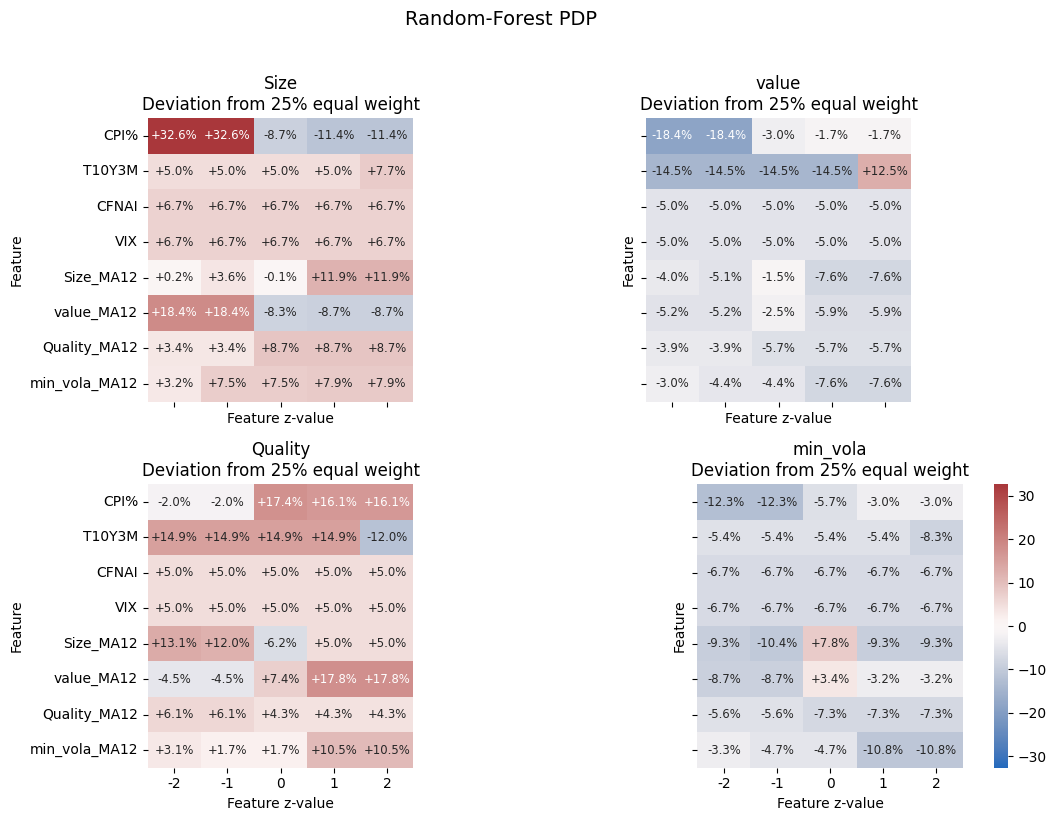

In [284]:
# ── Combined PDP heat-maps for Random-Forest (RF) and Gradient-Boost (XGB) ──
if compute_pdp:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # ===== 0) Common settings =================================================
    z_grid    = np.array([-2, -1, 0, 1, 2])            # standard-score grid
    eq_w      = 1.0 / len(FACTORS)                     # e.g. 0.25 if 4 factors
    eq_w_pct  = eq_w * 100                             # 25.0 – used in titles
    fmt_pct   = lambda v: f"{v:+.1f}%"                 # helper for annotations

    # Helper that draws a 2×2 heat-map panel for a dict {factor → DataFrame}
    def plot_panel(pdp_dev, title_suffix):
        vlim = max(df.abs().values.max() for df in pdp_dev.values())
        annot = {f: df.applymap(fmt_pct) for f, df in pdp_dev.items()}

        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
        axes = axes.flatten()
        for ax, fac in zip(axes, pdp_dev.keys()):
            sns.heatmap(
                pdp_dev[fac], ax=ax,
                cmap="vlag", center=0,
                vmin=-vlim, vmax=+vlim,
                annot=annot[fac], fmt="",
                cbar=(ax is axes[-1]),
                annot_kws={"fontsize": "small"}
            )
            ax.set_aspect(1 / 1.5)
            ax.set_title(f"{fac}\nDeviation from {eq_w_pct:.0f}% equal weight")
            ax.set_xlabel("Feature z-value")
            ax.set_ylabel("Feature")
        plt.suptitle(title_suffix, y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------------------------
    # 1) Random-Forest PDP (if rf_model & X_train are defined)
    # -------------------------------------------------------------------------
    if RF and "rf_model" in globals() and "X_train" in globals():
        pdp_rf = {fac: pd.DataFrame(index=FEATURES, columns=z_grid, dtype=float)
                  for fac in FACTORS}

        for feat in FEATURES:
            mu, sd = X_train[feat].mean(), X_train[feat].std()
            for z in z_grid:
                x_val        = mu + z * sd
                X_tmp        = X_train.copy()
                X_tmp[feat]  = x_val
                avg_p        = rf_model.predict_proba(X_tmp).mean(axis=0)
                for cls, p in zip(rf_model.classes_, avg_p):
                    pdp_rf[cls].at[feat, z] = p

        pdp_rf_dev = {f: (df - eq_w) * 100 for f, df in pdp_rf.items()}
        plot_panel(pdp_rf_dev, "Random-Forest PDP")

    # -------------------------------------------------------------------------
    # 2) Gradient-Boosting PDP (if xgb_model & X_train are defined)
    # -------------------------------------------------------------------------
    if GB and "xgb_model" in globals() and "X_train" in globals():
        # map numeric code → factor name from the last GB fit
        y_cat   = y_train.astype("category")
        mapping = dict(enumerate(y_cat.cat.categories))

        pdp_xgb = {fac: pd.DataFrame(index=FEATURES, columns=z_grid, dtype=float)
                   for fac in mapping.values()}

        for feat in FEATURES:
            mu, sd = X_train[feat].mean(), X_train[feat].std()
            for z in z_grid:
                x_val        = mu + z * sd
                X_tmp        = X_train.copy()
                X_tmp[feat]  = x_val
                avg_p        = xgb_model.predict_proba(X_tmp).mean(axis=0)
                for ci, code in enumerate(xgb_model.classes_):
                    fac = mapping[code]
                    pdp_xgb[fac].at[feat, z] = avg_p[ci]

        pdp_xgb_dev = {f: (df - eq_w) * 100 for f, df in pdp_xgb.items()}
        plot_panel(pdp_xgb_dev, "XGBoost PDP")

    # -------------------------------------------------------------------------
    # 3) Graceful notification if either model is missing
    # -------------------------------------------------------------------------
    if (RF and "rf_model" not in globals()) or (GB and "xgb_model" not in globals()):
        print("⛔  PDP not drawn for one or both models because the model "
              "object (rf_model / xgb_model) or X_train is not in scope.")


###By feature plots

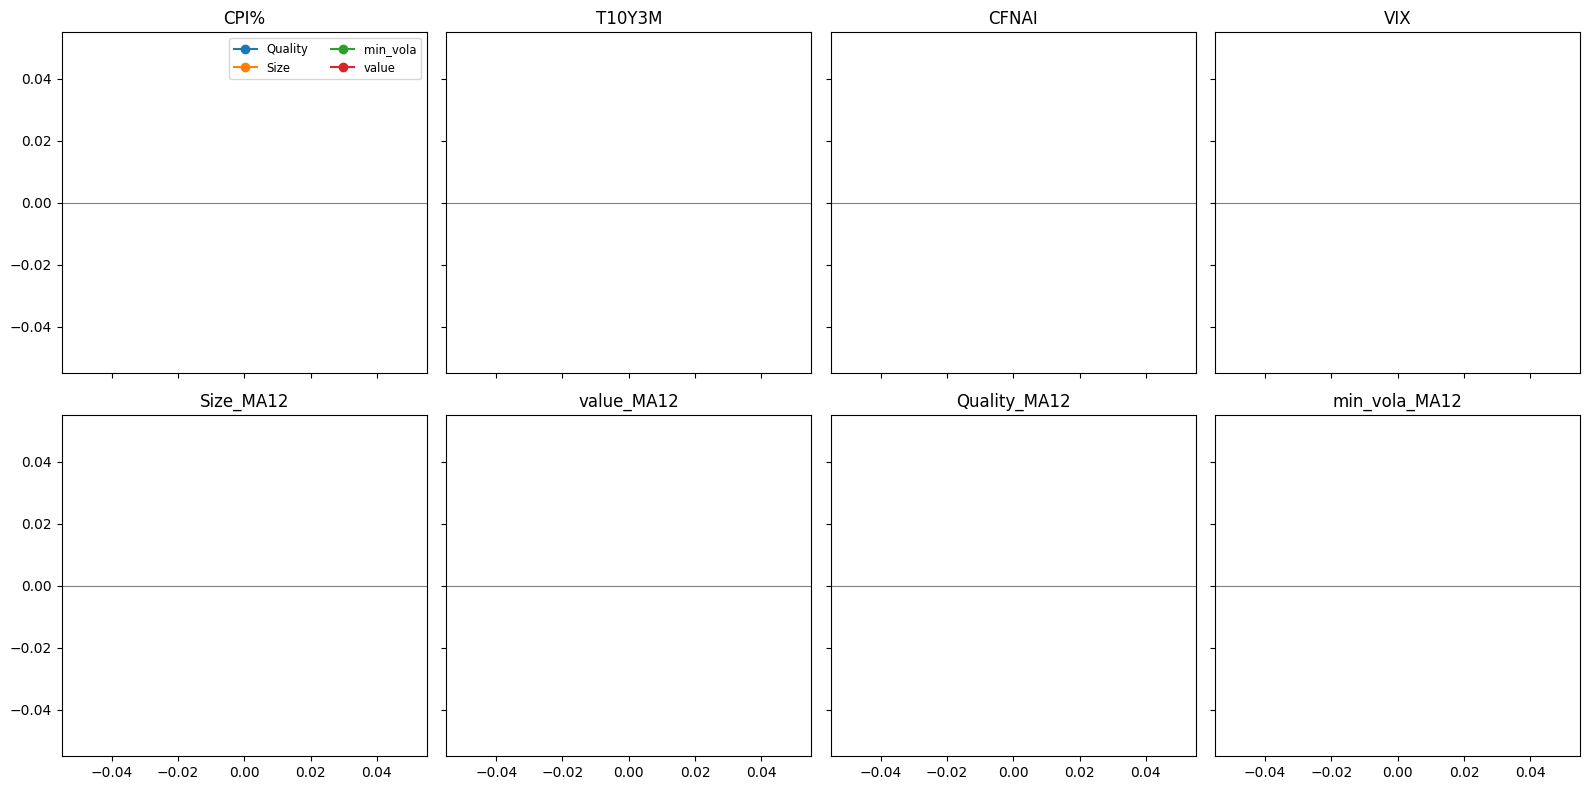

In [285]:
if RF and compute_pdp:
  fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
  axes = axes.flatten()
  for ax, feat in zip(axes, FEATURES):
      for fac, df in pdp_dfs.items():
          # Convert to %‑pt dev:
          dev = (df.loc[feat] - eq_w) * 100
          ax.plot(z_grid, dev, marker='o', label=fac)
      ax.set_title(feat)
      ax.axhline(0, color='gray', lw=0.8)
      if feat == FEATURES[0]:
          ax.legend(fontsize='small', ncol=2)
  plt.tight_layout()

,Probability
Size,0.0%
value,20.0%
Quality,20.0%
min_vola,60.0%


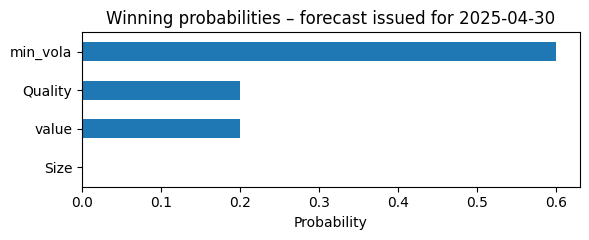

In [306]:
import pandas as pd
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# Function: show_probs
#     • date_input – any string accepted by pd.to_datetime
# ─────────────────────────────────────────────────────────────
def show_probs(date_input: str) -> None:
    requested = pd.to_datetime(date_input)

    mask = results_df_rf["Predicted_month"] <= requested
    if mask.any():
        idx_use = results_df_rf.loc[mask, "Predicted_month"].idxmax()
    else:
        idx_use = results_df_rf["Predicted_month"].idxmin()
        print("Requested date predates first model run – showing earliest "
              f"available prediction ({results_df_rf.at[idx_use, 'Predicted_month'].date()}).")

    row   = results_df_rf.loc[idx_use]
    probs = (pd.Series(row["Predicted_Probabilities"], index=FACTORS,
                       name="Probability").sort_values())

    display(probs.to_frame().style.format("{:.1%}"))

    ax = probs.plot(kind="barh", figsize=(6, 2.5))
    ax.set_xlabel("Probability")
    ax.set_title(f"Winning probabilities – forecast issued for "
                 f"{row['Predicted_month'].date()}")
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────
# USER-CONFIGURABLE DATE → edit this and run the cell
# ─────────────────────────────────────────────────────────────
DATE_REQUESTED = "2025-05-30"   # ← change me to any date you like

show_probs(DATE_REQUESTED)


##SHAP


In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# ────────────────
# 1) Build the long DataFrame from shap_data
# ────────────────
records = []
for rec in shap_data:
    month = rec['month']
    mat   = rec['shap_values']  # shape = (n_factors, n_features)
    for i, fac in enumerate(FACTORS):
        for j, feat in enumerate(FEATURES):
            records.append({
                'month':      pd.to_datetime(month),
                'factor':     fac,
                'feature':    feat,
                'shap_value': mat[i, j]
            })
shap_df = pd.DataFrame(records)

# ────────────────
# 2) Interactive controls
# ────────────────
start_picker = widgets.DatePicker(
    description="Start:",
    value=shap_df['month'].min().date()
)
end_picker = widgets.DatePicker(
    description="End:",
    value=shap_df['month'].max().date()
)
agg_dropdown = widgets.Dropdown(
    options=['average', 'mean', 'sum'],
    value='average',
    description='Aggregate:'
)

controls = widgets.HBox([start_picker, end_picker, agg_dropdown])

# ────────────────
# 3) Plot function
# ────────────────
def update_plot(start_date, end_date, agg):
    df = shap_df[
        (shap_df['month'] >= pd.to_datetime(start_date)) &
        (shap_df['month'] <= pd.to_datetime(end_date))
    ]
    if df.empty:
        print("No data in that range.")
        return

    grouped = df.groupby(['factor','feature'], observed=True)['shap_value']
    if agg in ('average', 'mean'):
        df_agg = grouped.mean().reset_index()
    else:  # 'sum'
        df_agg = grouped.sum().reset_index()

    pivot = (
        df_agg
          .pivot(index='factor', columns='feature', values='shap_value')
          .reindex(index=FACTORS, columns=FEATURES)
          .fillna(0)
    )

    fig, ax = plt.subplots(figsize=(10, len(FACTORS)*0.5))
    left = np.zeros(len(pivot))
    for feat in FEATURES:
        vals = pivot[feat].values
        ax.barh(pivot.index, vals, left=left, label=feat)
        left += vals

    ax.set_xlabel(f"SHAP {agg}")
    ax.set_title(f"SHAP {agg} from {start_date} to {end_date}")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ────────────────
# 4) Display everything
# ────────────────
out = widgets.interactive_output(
    update_plot,
    {
      'start_date': start_picker,
      'end_date':   end_picker,
      'agg':        agg_dropdown
    }
)

display(controls, out)


Output()

In [314]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, ipywidgets as w
from IPython.display import display, clear_output

# ─────────────────────────────────────────────────────────────
# util: grab the SHAP snapshot that was available on / before a date
# ─────────────────────────────────────────────────────────────
def _snapshot(date_req: pd.Timestamp):
    snaps = [s for s in shap_data if s["month"] <= date_req]
    if not snaps:
        raise ValueError("No SHAP data available on or before that date.")
    return max(snaps, key=lambda s: s["month"])

# ─────────────────────────────────────────────────────────────
# widget & callback
# ─────────────────────────────────────────────────────────────
pick_date = w.DatePicker(
    description="Forecast date",
    value=shap_data[-1]["month"].date()     # default = latest forecast
)
out = w.Output()

def _draw(change=None):
    with out:
        clear_output(wait=True)

        # 1 ─ forecast snapshot + probs
        snap   = _snapshot(pd.Timestamp(pick_date.value))
        shap_m = np.asarray(snap["shap_values"])        # shape (n_cls, n_feat)

        row    = results_df_rf.loc[
                   results_df_rf["Predicted_month"] == snap["month"]
                 ].iloc[0]
        probs  = np.asarray(row["Predicted_Probabilities"])
        win_ix = probs.argmax()
        winner = FACTORS[win_ix]

        # 2 ─ “edge” per feature = winner’s SHAP − mean(other SHAPs)
        edge   = shap_m[win_ix] - shap_m[np.arange(len(FACTORS)) != win_ix].mean(axis=0)
        edge_pp = edge * 100                            # percentage-points
        s      = (pd.Series(edge_pp, index=FEATURES)
                    .sort_values(key=np.abs, ascending=True))

        # 3 ─ bar plot
        plt.figure(figsize=(6, 3.8))
        cols = ["#3b7ddd" if v > 0 else "#d35f5f" for v in s]
        s.plot(kind="barh", color=cols)
        plt.axvline(0, lw=0.8, color="black")
        plt.title(f"{winner}: what pushed it ahead – forecast for {snap['month'].date()}")
        plt.xlabel("Winner’s edge vs. peer average  (percentage-points)")
        plt.tight_layout()
        plt.show()

        # 4 ─ numeric table
        display(s.sort_values(key=np.abs, ascending=False)
                  .to_frame("Edge (pp)").style.format("{:+.2f}"))

_draw()
pick_date.observe(_draw, names="value")
display(pick_date, out)


DatePicker(value=datetime.date(2025, 5, 31), description='Forecast date')

Output()

In [319]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

# ── utility ────────────────────────────────────────────────────────────────
def _snapshot_before(ts: pd.Timestamp):
    """Most-recent SHAP snapshot on/ before ts."""
    snaps = [s for s in shap_data if s["month"] <= ts]
    if not snaps:
        raise ValueError("No forecast available on or before that date.")
    return max(snaps, key=lambda s: s["month"])

# ── widgets ────────────────────────────────────────────────────────────────
date_pick   = w.DatePicker(
    description="Forecast date",
    value=results_df_rf["Predicted_month"].max().date(),   # latest by default
)
factor_pick = w.Dropdown(
    options=FACTORS,
    description="Factor",
)                           # value filled automatically once date is chosen

out = w.Output()

# ── callback ───────────────────────────────────────────────────────────────
def _redraw(_=None):
    with out:
        clear_output(wait=True)

        # 1) grab snapshot + probabilities
        snap      = _snapshot_before(pd.Timestamp(date_pick.value))
        shap_mat  = np.asarray(snap["shap_values"])        # (n_cls, n_feat)

        row       = results_df_rf.loc[
                      results_df_rf["Predicted_month"] == snap["month"]
                    ].iloc[0]
        probs     = np.asarray(row["Predicted_Probabilities"])
        winner_ix = probs.argmax()
        winner    = FACTORS[winner_ix]

        # auto-select winner if the user hasn't overridden dropdown yet
        if factor_pick.value is None or factor_pick.value not in FACTORS:
            factor_pick.value = winner                         # initialise
        # (if user later changes the drop-down, we won't override it)

        f        = factor_pick.value
        f_ix     = FACTORS.index(f)

        # 2) standard SHAP values for that factor  (to percentage-points)
        delta_pp = shap_mat[f_ix] * 100
        s        = pd.Series(delta_pp, index=FEATURES, name="ΔSHAP (pp)")\
                    .sort_values(key=np.abs, ascending=True)

        # 3) bar plot
        plt.figure(figsize=(7, 4))
        colours = ["#3b7ddd" if v > 0 else "#d35f5f" for v in s]
        s.plot(kind="barh", color=colours)
        plt.axvline(0, color="black", lw=0.8)
        plt.title(f"{f}: feature contributions – forecast {snap['month'].date()}")
        plt.xlabel("Change in probability (percentage points)")
        plt.tight_layout()
        plt.show()

        # 4) numeric table
        display(s.sort_values(key=np.abs, ascending=False)
                  .to_frame().style.format("{:+.2f}"))

# initial render + hook-up
_redraw()
date_pick.observe(_redraw, names="value")
factor_pick.observe(_redraw, names="value")
display(w.HBox([date_pick, factor_pick]), out)


Output()

##Permutation

In [287]:
###############################################################################
# CELL 2 —  Interactive permutation-importance explorer
###############################################################################
if RF and compute_permutation_importance:
    import pandas as pd, matplotlib.pyplot as plt, ipywidgets as widgets
    from IPython.display import display

    if not perm_importances_list:
        print("⚠️  No permutation-importance rows collected; run the training cell first.")
    else:
        # 1) Build DataFrame
        perm_df = pd.DataFrame(
            perm_importances_list,
            index=pd.to_datetime(months_list),
            columns=FEATURES
        ).sort_index()

        # 2) Widgets
        date_opts = list(perm_df.index)
        start_w   = widgets.Dropdown(options=date_opts, value=date_opts[0],  description="Start:")
        end_w     = widgets.Dropdown(options=date_opts, value=date_opts[-1], description="End:")
        agg_w     = widgets.RadioButtons(options=["mean", "median"], value="mean", description="Agg.")

        # 3) Callback
        def plot_perm_range(start, end, agg):
            if start > end:
                start, end = end, start
            block = perm_df.loc[start:end]
            if block.empty:
                print("No data for this range.")
                return
            vals  = block.mean() if agg == "mean" else block.median()
            title = f"{agg.capitalize()} Permutation Importance\n{start.date()} → {end.date()}"
            plt.figure(figsize=(10, 6))
            vals.sort_values().plot.barh()
            plt.title(title)
            plt.xlabel("Importance")
            plt.tight_layout()
            plt.show()

        ui = widgets.interactive(plot_perm_range, start=start_w, end=end_w, agg=agg_w)
        display(ui)


interactive(children=(Dropdown(description='Start:', options=(Timestamp('2000-06-30 00:00:00'), Timestamp('200…

##Confusion Matrix

TypeError: '<' not supported between instances of 'float' and 'str'

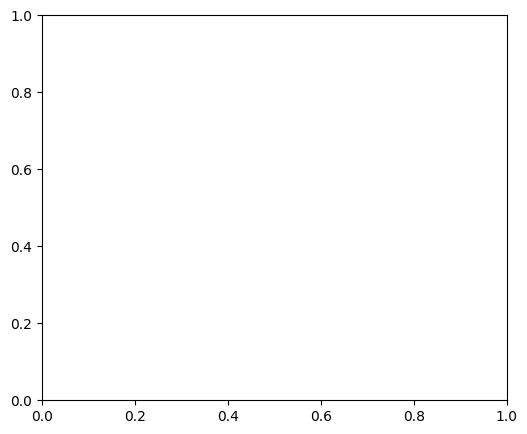

In [288]:
"""
Comprehensive evaluation script
===============================

Outputs
-------
1.  Row-normalised **confusion-matrix heat-maps** + a printed numeric table
    for each model
2.  **Single combined per-factor table** with a merged header row
    (Random Forest vs Gradient Boosting)
3.  Headline **Overall-Performance Summary** table
"""

# ─────────────────────────────────────────────────────────────
# 0. Imports and expected inputs
# ─────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from IPython.display import display

# The notebook/environment must already provide:
#   FACTORS      : list[str]   – the four factor names in display order
#   results_dfs  : dict[str → DataFrame] with columns
#                   • “Actual_Winner”
#                   • “Predicted_Winner”
# ------------------------------------------------------------

labels = FACTORS
items  = list(results_dfs.items())              # [('Random Forest', df), ('Gradient Boosting', df)]

# ─────────────────────────────────────────────────────────────
# 1. Confusion-matrix heat-maps **and** printed tables
# ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, len(items), figsize=(6 * len(items), 5), squeeze=False)
axes = axes[0]

for idx, (model_name, df_res) in enumerate(items):
    cm     = confusion_matrix(df_res.Actual_Winner, df_res.Predicted_Winner, labels=labels)
    cm_pct = (cm / cm.sum(axis=1, keepdims=True)) * 100

    # Heat-map
    sns.heatmap(
        cm_pct, annot=True, fmt=".1f", cmap="Blues",
        cbar=(idx == len(items) - 1),
        xticklabels=labels, yticklabels=labels,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{model_name} (row %)\nn = {len(df_res)}")
    axes[idx].set_xlabel("Predicted winner")
    axes[idx].set_ylabel("True winner")

    # Printed numeric table
    print(f"\nConfusion matrix for {model_name} (row %):")
    print(pd.DataFrame(cm_pct, index=labels, columns=labels)
            .to_string(float_format=lambda x: f"{x:.1f}"))

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 2. Combined per-factor metrics table (RF vs GB)
# ─────────────────────────────────────────────────────────────
per_factor_tables = {}

for model_name, df_res in items:
    y_true, y_pred = df_res.Actual_Winner, df_res.Predicted_Winner

    rep = classification_report(
        y_true, y_pred,
        labels=labels, target_names=labels,
        output_dict=True, zero_division=0
    )

    df_cr = (pd.DataFrame(rep).T
               .drop('accuracy', errors='ignore')
               .rename(columns={'support': 'Samples'}))

    for col in ['precision', 'recall', 'f1-score']:
        df_cr[col] = (df_cr[col] * 100).round(1)
    df_cr['Samples'] = df_cr['Samples'].astype(int)

    df_cr = (df_cr.rename(columns={'precision':'Precision',
                                   'recall':'Recall',
                                   'f1-score':'F1-score'})
                   [['Precision', 'Recall', 'F1-score', 'Samples']])

    per_factor_tables[model_name] = df_cr

# Concatenate side-by-side → MultiIndex columns: level-0=model, level-1=metric
combined = pd.concat(
    {m: tbl.drop(columns='Samples') for m, tbl in per_factor_tables.items()},
    axis=1
)

# Single shared Samples column
combined[('', 'Samples')] = next(iter(per_factor_tables.values()))['Samples']
combined = combined.reindex(
    columns=[c for c in combined.columns if c[1] != 'Samples'] + [('', 'Samples')]
)
combined.columns.set_names(['Model', 'Metric'], inplace=True)

print("\n## Per-Factor Metrics: Random Forest vs Gradient Boosting\n")
display(
    combined.style
            .format(lambda x: f"{x:.1f}%" if isinstance(x, (float, np.floating))
                                   else "{:d}".format(x))
            .set_caption("Per-Factor Metrics (Combined)")
            .set_table_styles(
                [
                    {'selector': 'th', 'props': [('text-align', 'center')]},
                    {'selector': 'th.col_heading.level0',
                     'props': [('border-bottom', '1pt solid black')]}
                ]
            )
)

# ─────────────────────────────────────────────────────────────
# 3. Overall-performance summary
# ─────────────────────────────────────────────────────────────
summary_rows = []
for model_name, df_res in items:
    y_true, y_pred = df_res.Actual_Winner, df_res.Predicted_Winner
    summary_rows.append({
        'Model':              model_name,
        'Accuracy (%)':       round(accuracy_score(y_true, y_pred) * 100, 1),
        'Precision (wtd %)':  round(precision_score(y_true, y_pred, average='weighted') * 100, 1),
        'Recall  (wtd %)':    round(recall_score   (y_true, y_pred, average='weighted') * 100, 1),
        'F1 (wtd %)':         round(f1_score       (y_true, y_pred, average='weighted') * 100, 1),
        'Samples':            len(y_true)
    })

summary_df = pd.DataFrame(summary_rows).set_index('Model')

print("\n### Overall Performance Summary ###\n")
display(
    summary_df.style
              .format({
                  'Accuracy (%)':      '{:.1f}%',
                  'Precision (wtd %)': '{:.1f}%',
                  'Recall  (wtd %)':   '{:.1f}%',
                  'F1 (wtd %)':        '{:.1f}%',
                  'Samples':           '{:d}'
              })
              .set_caption("Overall Performance Summary")
)

##Feature importance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume FEATURES is defined (e.g., FEATURES = ['CPI%', 'T10YFF', 'LEI%', 'Amihud', 'GARCH_1M'])
# and results_dfs is a dictionary with keys like "RF", "GB", (and maybe "Hybrid")
# where each value is a DataFrame that has a column "Feature_Importances" (an array).

# 1. Compute overall average feature importances for each model.
model_importances = {}
for model_key, df in results_dfs.items():
    # Stack the arrays from the "Feature_Importances" column and average over predictions.
    model_importances[model_key] = np.vstack(df['Feature_Importances'].values).mean(axis=0)

# 2. Create a DataFrame from the computed importances.
# Rows: features, Columns: model keys.
importance_df = pd.DataFrame(model_importances, index=FEATURES)

# Optional: sort features by overall mean importance (averaged across models) so that
# the most important features appear on top.
importance_df['Mean'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values(by='Mean', ascending=False)
sorted_features = importance_df.index.tolist()
importance_df = importance_df.drop(columns=['Mean'])

# 3. Plot a grouped horizontal bar chart.
models = importance_df.columns.tolist()
n_models = len(models)
n_features = len(sorted_features)
y = np.arange(n_features)  # base positions for each feature group
bar_height = 0.8 / n_models  # total group thickness is 0.8

fig, ax = plt.subplots(figsize=(10, max(4, n_features * 0.6)))
for i, model in enumerate(models):
    # Calculate an offset for each model in the group.
    offset = (i - n_models/2) * bar_height + bar_height/2
    ax.barh(y + offset, importance_df.loc[sorted_features, model], height=bar_height, label=model)

ax.set_yticks(y)
ax.set_yticklabels(sorted_features)
ax.invert_yaxis()  # so the top feature is at the top
ax.set_xlabel("Average Feature Importance")
ax.set_title("Comparison of Overall Average Feature Importances Across Models")
ax.legend(title="Model")
plt.tight_layout()
plt.show()


##Allocation chart

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── 0.  Figure parameters ───────────────────────────────────────────────────────
panel_height = 3.0
fig_width    = 12
num_models   = len(results_dfs)
fig_height   = panel_height * num_models

fig, axes = plt.subplots(
    nrows=num_models, ncols=1,
    figsize=(fig_width, fig_height),
    sharex=True,
)

if num_models == 1:      # keep iterable
    axes = [axes]

# ── 1.  Get the GLOBAL date span so every axis uses identical limits ───────────
all_dates = pd.concat(
    [pd.to_datetime(df["Predicted_month"], errors="coerce") for df in results_dfs.values()]
).dropna()
date_min, date_max = all_dates.min(), all_dates.max()

# ── 2.  Plot each model ────────────────────────────────────────────────────────
for ax, (model_key, df_model) in zip(axes, results_dfs.items()):
    df_temp = df_model.copy()

    # Parse dates & clean
    df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors="coerce")
    df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month")

    # Probability matrix → DataFrame
    full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
    probability_df         = pd.DataFrame(full_probs, columns=FACTORS)
    probability_df["Date"] = df_temp["Predicted_month"].values

    # Stackplot
    ax.stackplot(
        probability_df["Date"],
        [probability_df[col] for col in FACTORS],
        labels=FACTORS,
        alpha=0.8,
    )

    # Aesthetics
    ax.set_title(f"{model_key} Outperforming Probabilities", fontsize=12, pad=6)
    ax.set_ylabel("Probability", fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# ── 3.  Remove x-axis padding & apply shared limits ────────────────────────────
for ax in axes:
    ax.set_xlim(date_min, date_max)  # exact span
    ax.margins(x=0)                  # turn off the default 5% padding

# Legend only on the first axis (or wherever you prefer)
axes[0].legend(
    loc="upper right",
    fontsize="x-small",
    title="Factors",
    frameon=True,
    framealpha=1.0,
    facecolor="white",
    edgecolor="black",
)

# ── 4.  Final touches ──────────────────────────────────────────────────────────
axes[-1].set_xlabel("Date", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(left=0.04, right=0.995)   # trims the white border outside axes
plt.show()

##Factor weight analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Toggle:
combine_all_models = False  # Set to True to combine all models into the same charts; False for individual charts per model

# Set the date range for viewing.
start_date = pd.to_datetime("1968-07-30")
end_date   = pd.to_datetime("2024-11-30")

# Define static equal weight value.
equal_weight = 1 / len(FACTORS)  # e.g., for 5 factors equal_weight = 0.20

if combine_all_models:
    # Combined charts: One set of subplots (one per factor) for all models.
    n_factors = len(FACTORS)
    fig, axs = plt.subplots(n_factors, 1, figsize=(12, 4 * n_factors), sharex=False)
    if n_factors == 1:
        axs = [axs]  # ensure axs is iterable

    for i, factor in enumerate(FACTORS):
        ax = axs[i]
        min_dates = []
        max_dates = []

        # Loop through each model's results
        for model_key, df_model in results_dfs.items():
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            # Stack predicted probabilities into a DataFrame.
            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            ax.plot(filtered_df["Date"], filtered_df[factor],
                    label=f"{factor}_{model_key}", linewdth=0.6)

            min_dates.append(filtered_df["Date"].min())
            max_dates.append(filtered_df["Date"].max())

        # Set x-axis limits to exactly the data span (if any data exist)
        if min_dates and max_dates:
            ax.set_xlim(min(min_dates), max(max_dates))

        # Draw the static equal weight horizontal line.
        ax.axhline(equal_weight, color='black', linestyle='--',
                   label=f"Equal Weight ({equal_weight:.2%})")

        ax.set_title(f"{factor} Predicted Probabilities Across Models", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(loc='best', fontsize='small')

    plt.xlabel("Date", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    # Separate charts: Loop over each model and for each factor create individual charts.
    for model_key, df_model in results_dfs.items():
        for factor in FACTORS:
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            plt.figure(figsize=(12, 4))
            plt.plot(filtered_df["Date"], filtered_df[factor],
                     label=f"{factor} Predicted Probability", color='blue', linewidth=0.6)

            plt.axhline(equal_weight, color='black', linestyle='--',
                        label=f"Equal Weight ({equal_weight:.2%})")

            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] > equal_weight),
                             interpolate=True, color='green', alpha=0.3, label='Overweight')
            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] < equal_weight),
                             interpolate=True, color='red', alpha=0.3, label='Underweight')

            plt.title(f"{model_key} - Over/Under Weight for {factor}")
            plt.xlabel("Date")
            plt.ylabel("Probability")
            plt.ylim(0, 1)
            # Set x-axis limits to exactly where data exists.
            plt.xlim(filtered_df["Date"].min(), filtered_df["Date"].max())
            plt.legend(loc='best')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


##Total outperforming probabilities

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# ----------------------------------------------------
# 1. Compute average predicted probabilities per model
# ----------------------------------------------------
avg_probs_dict = {}
avg_highest_factor_weight_dict = {}

for model_key, df_model in results_dfs.items():
    full_probs = np.vstack(df_model["Predicted_Probabilities"].values)

    # 1a. Compute the average probabilities across all rows
    avg = full_probs.mean(axis=0)
    avg_probs_dict[model_key] = pd.Series(avg, index=FACTORS)

    # 1b. Compute the average of the highest weight factor
    #     (for each time step, pick the max factor weight, then average those)
    avg_highest_factor_weight_dict[model_key] = full_probs.max(axis=1).mean()

# Create a DataFrame where rows = models, columns = factors
avg_probs_df = pd.DataFrame(avg_probs_dict).T
avg_probs_df.index.name = "Model"
avg_probs_df = avg_probs_df.round(4)

# ----------------------------------------------------
# 2. Generate consistent factor colors from stackplot
# ----------------------------------------------------
# Use a dummy stackplot to extract the assigned factor colors
_, ax_dummy = plt.subplots()
dummy_data = np.random.rand(10, len(FACTORS))
dummy_dates = pd.date_range("2000-01-01", periods=10)
stack = ax_dummy.stackplot(dummy_dates, dummy_data.T, labels=FACTORS, alpha=0.8)
plt.close()  # We don’t want to display this

# Build color map: factor name → RGBA color
factor_colors = {factor: poly.get_facecolor()[0] for factor, poly in zip(FACTORS, stack)}

# ----------------------------------------------------
# 3. Display HTML Table of average probabilities
# ----------------------------------------------------
html_table = avg_probs_df.reset_index().to_html(index=False, classes="table table-striped table-bordered", border=0)
display(HTML("<h3>Average Outperforming Probabilities by Model</h3>" + html_table))

# ----------------------------------------------------
# 4. Print average of the highest factor weight by model
# ----------------------------------------------------
display(HTML("<h4>Average of the Highest Factor Weight by Model</h4>"))
for model_key, avg_highest in avg_highest_factor_weight_dict.items():
    display(HTML(f"<p><strong>{model_key}:</strong> {avg_highest:.4f}</p>"))

# ----------------------------------------------------
# 5. Stacked Bar Chart with Consistent Colors and Labels
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(avg_probs_df))
x = np.arange(len(avg_probs_df))

for factor in FACTORS:
    values = avg_probs_df[factor].values
    bars = ax.bar(x, values, bottom=bottom,
                  label=factor,
                  color=factor_colors[factor],
                  edgecolor="white",
                  linewidth=0.5)

    # Centered labels
    for bar, val in zip(bars, values):
        if val > 0.03:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{val * 100:.1f}%",
                ha="center", va="center", fontsize=9, color="white"
            )

    bottom += values

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(avg_probs_df.index)
ax.set_ylabel("Strategy average factor weights")
ax.set_title("Strategy average factor weights")
ax.legend(title="Factor", loc="upper right")
plt.tight_layout()
plt.show()


#Return data

In [ ]:
import pandas as pd
from IPython.display import display

# ==============================================================================
# Step 0: Define column orders based on your requirements
# ------------------------------------------------------------------------------
# Common columns that are identical across all models.
common_cols = ['Predicted_month', 'Mkt', 'RF', 'Mkt-RF', 'Us_standard'] + FACTORS + ['Equal_Weight_Return', 'Actual_Winner']

# Model-specific columns that will be renamed.
model_specific_cols = ['Allocated_Return', 'Predicted_Winner']

# ==============================================================================
# Step 1. Build a base common DataFrame from one model's merged results.
# ------------------------------------------------------------------------------
# Take the first model as the base to extract common columns.
base_key, base_df = list(results_dfs.items())[0]
base_df = base_df.copy()
base_df['Predicted_month'] = pd.to_datetime(base_df['Predicted_month'], errors='coerce')

# Merge with df_sorted (the master DataFrame sorted by date) on date.
base_df_local = base_df.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')
common_df = base_df_local[[c for c in common_cols if c in base_df_local.columns]].copy()

# ==============================================================================
# Step 2. Process each model individually to extract the model-specific columns.
# ------------------------------------------------------------------------------
# We'll assign a new display name using numbering such that each model gets:
# "ML{number}: {Model Name}"
model_dfs = []         # Will hold one DataFrame per model.
new_model_names = []   # To store new model names.
for i, (model_key, df_model) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_key}"  # New display name.
    new_model_names.append(new_model_name)

    df_temp = df_model.copy()
    df_temp['Predicted_month'] = pd.to_datetime(df_temp['Predicted_month'], errors='coerce')

    # Merge with df_sorted on 'Predicted_month' = 'Date'
    df_temp_local = df_temp.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')

    # Keep only the 'Predicted_month' plus the model-specific columns.
    subset_cols = ['Predicted_month'] + [col for col in model_specific_cols if col in df_temp_local.columns]
    df_subset = df_temp_local[subset_cols].copy()

    # Rename model-specific columns with the new model name.
    rename_dict = {}
    for col in model_specific_cols:
        if col in df_subset.columns:
            rename_dict[col] = f"{new_model_name} {col}"
    df_subset.rename(columns=rename_dict, inplace=True)

    model_dfs.append(df_subset)

# ==============================================================================
# Step 3. Merge each model-specific DataFrame with the common DataFrame.
# ------------------------------------------------------------------------------
combined_df = common_df.copy()
for df_sub in model_dfs:
    combined_df = combined_df.merge(df_sub, on='Predicted_month', how='left')

# ==============================================================================
# Step 4. Reorder the columns to match the desired order.
# ------------------------------------------------------------------------------
benchmark_cols = ['Mkt', 'RF', 'Mkt-RF', 'Us_standard']
common_order = ['Predicted_month'] + benchmark_cols + FACTORS
# Model-specific allocated return columns.
allocated_cols = [f"{name} Allocated_Return" for name in new_model_names]
# Model-specific predicted winner columns.
predicted_cols = [f"{name} Predicted_Winner" for name in new_model_names]

final_order = common_order + ['Equal_Weight_Return'] + allocated_cols + ['Actual_Winner'] + predicted_cols
final_order = [col for col in final_order if col in combined_df.columns]

combined_df = combined_df[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ==============================================================================
# Step 5. Display the final combined results table.
# ------------------------------------------------------------------------------
display(combined_df)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).max())


In [ ]:
import pandas as pd
import numpy as np
import textwrap

# Define your date range
start_date = pd.to_datetime('2000-01-01')
end_date   = pd.to_datetime('2024-12-30')

# Create a filtered copy of combined_df (so the original data isn't lost)
filtered_df = combined_df.loc[
    (combined_df['Predicted_month'] >= start_date) &
    (combined_df['Predicted_month'] <= end_date)
].copy()

# Ensure "Year" column exists in filtered_df
if 'Year' not in filtered_df.columns:
    filtered_df['Year'] = filtered_df['Predicted_month'].dt.year

# Identify ML return columns and create a name map to remove "Allocated_Return"
ml_return_cols = [c for c in filtered_df.columns if 'Allocated_Return' in c]
ml_name_map = {ml: ml.replace("Allocated_Return", "").strip() for ml in ml_return_cols}

# Helper: Compute annual metrics (RF-adjusted)
def compute_annual_metrics(returns: pd.Series, rf: pd.Series):
    returns = returns.dropna()
    if returns.empty:
        return np.nan, np.nan, np.nan
    rf = rf.reindex(returns.index)
    ann_ret = (1 + returns).prod() - 1
    ann_rf  = (1 + rf).prod() - 1
    ann_ex_ret = ann_ret - ann_rf
    ann_vol = (returns - rf).std() * np.sqrt(12)
    ann_sharpe = ann_ex_ret / ann_vol if ann_vol else np.nan
    return ann_ret, ann_vol, ann_sharpe

# Build df_metrics (raw values) and df_excess (excess over Equal Weight)
metrics_rows, excess_rows = [], []
for year, grp in filtered_df.groupby('Year'):
    ew_ret, ew_vol, ew_sharpe = compute_annual_metrics(grp['Equal_Weight_Return'], grp['RF'])
    row_m = {'Year': year,
             'Equal_Weight Return': ew_ret,
             'Equal_Weight Vol':    ew_vol,
             'Equal_Weight Sharpe': ew_sharpe}
    row_e = {'Year': year}

    for ml in ml_return_cols:
        ml_short = ml_name_map[ml]
        ml_ret, ml_vol, ml_sharpe = compute_annual_metrics(grp[ml], grp['RF'])
        row_m[f"{ml_short} Return"]  = ml_ret
        row_m[f"{ml_short} Vol"]     = ml_vol
        row_m[f"{ml_short} Sharpe"]  = ml_sharpe

        row_e[f"{ml_short} Excess Return"]  = ml_ret - ew_ret
        row_e[f"{ml_short} Excess Vol"]     = ml_vol - ew_vol
        row_e[f"{ml_short} Excess Sharpe"]  = ml_sharpe - ew_sharpe

    metrics_rows.append(row_m)
    excess_rows.append(row_e)

df_metrics = pd.DataFrame(metrics_rows).set_index('Year').sort_index()
df_excess  = pd.DataFrame(excess_rows).set_index('Year').sort_index()

# Function: Insert newline breaks for column names longer than max_width characters.
def wrap_colname(colname, max_width=15):
    lines = textwrap.wrap(colname, width=max_width)
    return "\n".join(lines)

# Apply wrapping to all column names
df_metrics.columns = [wrap_colname(col) for col in df_metrics.columns]
df_excess.columns  = [wrap_colname(col) for col in df_excess.columns]

# Function: Style dataframe to enable multiline headers and format numbers with a max of 3 decimals.
def style_with_wrapping_and_format(df):
    styled = df.style.set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('white-space', 'pre-wrap'),  # allow multiline
                ('word-wrap', 'break-word')   # break long words
            ]
        }
    ]).format(lambda x: f"{x:.3f}" if isinstance(x, float) else x)
    return styled

# Display the raw metrics and excess metrics with formatted output.
display(style_with_wrapping_and_format(df_metrics))
display(style_with_wrapping_and_format(df_excess))

# -----------------------------------------------------------------
# Summary: Count how often each ML strategy "beats" Equal Weight.
#  - Excess Return is "better" if > 0.
#  - Excess Volatility is "better" if < 0.
#  - Excess Sharpe is "better" if > 0.
#
# Average excess metrics are now calculated from all observations.
# -----------------------------------------------------------------
summary_rows = []
total_years = len(df_excess)

def w(ml_short, suffix):
    return wrap_colname(f"{ml_short} {suffix}")

for ml in ml_return_cols:
    ml_short = ml_name_map[ml]
    ret_series    = df_excess[w(ml_short, "Excess Return")]
    vol_series    = df_excess[w(ml_short, "Excess Vol")]
    sharpe_series = df_excess[w(ml_short, "Excess Sharpe")]

    ret_pos_count    = (ret_series > 0).sum()
    vol_neg_count    = (vol_series < 0).sum()
    sharpe_pos_count = (sharpe_series > 0).sum()

    # Average excess metrics now computed over all observations:
    avg_ret    = ret_series.mean()
    avg_vol    = vol_series.mean()
    avg_sharpe = sharpe_series.mean()

    summary_rows.append({
        "Strategy": ml_short,
        "Excess Return (Positive) Count": f"{ret_pos_count}/{total_years}",
        "Avg Excess Return":   avg_ret,
        "Excess Vol (Negative) Count":    f"{vol_neg_count}/{total_years}",
        "Avg Excess Vol":      avg_vol,
        "Excess Sharpe (Positive) Count": f"{sharpe_pos_count}/{total_years}",
        "Avg Excess Sharpe":   avg_sharpe
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.columns = [wrap_colname(col) for col in summary_df.columns]

display(style_with_wrapping_and_format(summary_df))


##Cumulative returns table

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# PRELIMINARY: Use the merged multi-model table (combined_df)
# ---------------------------------------------------------------------
start_date = pd.to_datetime('2020-01-01')
end_date   = pd.to_datetime('2025-05-30')
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Rename benchmark column if present (using the first element of BENCHMARK)
rename_dict = {}
if BENCHMARK[0] in df_filtered.columns:
    rename_dict[BENCHMARK[0]] = 'Benchmark Return'
df_filtered.rename(columns=rename_dict, inplace=True)

# ---------------------------------------------------------------------
# Remove RF from factors (we exclude it)
factors_to_use = [fac for fac in FACTORS if fac.upper() != 'RF']

# Define possible benchmark columns (for cumulative returns).
possible_bench = ["Benchmark Return", "Mkt", "Mkt-RF", "Us_standard"]
benchmark_cols = [col for col in possible_bench if col in df_filtered.columns]

# ---------------------------------------------------------------------
# Calculate Equal-Weighted Returns based on factors_to_use.
if all(f in df_filtered.columns for f in factors_to_use):
    df_filtered['Equal Factor Weight Strategy Return'] = df_filtered[factors_to_use].mean(axis=1)
    equal_ret_col_list = ['Equal Factor Weight Strategy Return']
else:
    equal_ret_col_list = []

# ---------------------------------------------------------------------
# Predicted Winner Weighted Strategy Return:
# Use the base model's predicted winner column using new naming.
base_model_key = list(results_dfs.keys())[0]
base_model_new = f"ML1: {base_model_key}"  # First model is ML1.
base_model_pred_col = f"{base_model_new} Predicted_Winner"
if base_model_pred_col in df_filtered.columns:
    df_filtered['Predicted_Winner'] = df_filtered[base_model_pred_col]

def calc_winner_strategy(row):
    pred = row['Predicted_Winner']
    if pred in factors_to_use:
        other_factors = [f for f in factors_to_use if f != pred]
        if other_factors:
            return 0.5 * row[pred] + 0.5 * row[other_factors].mean()
        else:
            return row[pred]
    else:
        return row[factors_to_use].mean()

df_filtered['Predicted Winner Weighted Strategy Return'] = df_filtered.apply(calc_winner_strategy, axis=1)

# ---------------------------------------------------------------------
# Compute cumulative returns for each return series.
# We'll work on a copy for cumulative computations.
cum = df_filtered.copy()

# 1. For each model's allocated return (using new names).
allocated_cum_cols = []
new_model_names = [f"ML{i}: {model_key}" for i, model_key in enumerate(results_dfs.keys(), 1)]
for name in new_model_names:
    col_alloc = f"{name} Allocated_Return"
    if col_alloc in cum.columns:
        new_cum_col = col_alloc.replace("Allocated_Return", "Cumulative Allocated Return")
        cum[new_cum_col] = (1 + cum[col_alloc]).cumprod() - 1
        allocated_cum_cols.append(new_cum_col)

# 2. For equal factor weight returns.
if 'Equal Factor Weight Strategy Return' in cum.columns:
    cum['Equal Factor Weight Cumulative Return'] = (1 + cum['Equal Factor Weight Strategy Return']).cumprod() - 1
    equal_cum_cols = ['Equal Factor Weight Cumulative Return']
else:
    equal_cum_cols = []

# 3. For each benchmark column.
bench_cum_cols = []
# If "Benchmark Return" is available, use the actual benchmark name from BENCHMARK[0].
if "Benchmark Return" in cum.columns:
    new_bench_col = f"{BENCHMARK[0]} Cumulative Return"
    cum[new_bench_col] = (1 + cum["Benchmark Return"]).cumprod() - 1
    bench_cum_cols.append(new_bench_col)
# Process any other benchmark columns
for col in benchmark_cols:
    if col != "Benchmark Return":
        new_col = col + " Cumulative Return"
        cum[new_col] = (1 + cum[col]).cumprod() - 1
        bench_cum_cols.append(new_col)

# 4. For Predicted Winner Weighted Strategy Return.
if 'Predicted Winner Weighted Strategy Return' in cum.columns:
    cum['Predicted Winner Weighted Cumulative Return'] = (1 + cum['Predicted Winner Weighted Strategy Return']).cumprod() - 1

# 5. For each factor in factors_to_use: compute cumulative returns.
factor_cum_cols = []
for fac in factors_to_use:
    if fac in cum.columns:
        new_name = fac + " Cumulative"
        cum[new_name] = (1 + cum[fac]).cumprod() - 1
        factor_cum_cols.append(new_name)

# ---------------------------------------------------------------------
# Build the final cumulative returns table.
# Final order:
#   a. Common columns: Predicted_month, then benchmark cumulative returns, then factor cumulative returns.
#   b. Then Equal Factor Weight Cumulative Return.
#   c. Then each model's Cumulative Allocated Return.
#   d. Then Predicted Winner Weighted Cumulative Return.
# ---------------------------------------------------------------------
final_common_order = ['Predicted_month'] + bench_cum_cols + factor_cum_cols
final_order = final_common_order + equal_cum_cols + allocated_cum_cols
if 'Predicted Winner Weighted Cumulative Return' in cum.columns:
    final_order.append('Predicted Winner Weighted Cumulative Return')

final_order = [col for col in final_order if col in cum.columns]
cumulative_table = cum[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ---------------------------------------------------------------------
# Display the Final Cumulative Returns Table.
# ---------------------------------------------------------------------
print("Cumulative Returns Table:")
display(cumulative_table)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).max())

##Cumulative returns chart

In [ ]:
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────
# User-configurable toggles
# ────────────────────────────────────────────────────────────────────
cut_off_date        = pd.to_datetime("2000-01-01")   # ① where to rebase
show_50_50_strategy = False                          # keep your old toggles
show_benchmark      = True
use_log_scale       = True                           # ← log scale like the 3rd graph
shade_out_of_sample = True                           # ② grey shading toggle

# ────────────────────────────────────────────────────────────────────
# Prep the data
# ────────────────────────────────────────────────────────────────────
df_plot  = cumulative_table.copy()
start_dt = df_plot['Predicted_month'].min()
end_dt   = df_plot['Predicted_month'].max()

# Helper: rebase any cumulative-return series so it equals 1 at cut-off
def rebase(series, cut_date):
    """Convert cumulative-return series to wealth curve rebased to 1 at cut_date."""
    wealth = 1 + series            # turn cum-return into wealth
    base   = wealth.loc[series.index == cut_date]
    if not base.empty and base.iloc[0] != 0:          # protect against divide-by-0
        return wealth / base.iloc[0]
    else:
        return wealth / wealth.iloc[0]               # fallback: rebase to first point

# Apply rebasing to every cumulative series we intend to plot
rebased_cols = {}   # {col_name: rebased_series}
for col in df_plot.columns:
    if ("Cumulative" in col) and (col != "Predicted_month"):
        rebased_cols[col] = rebase(
            df_plot.set_index('Predicted_month')[col],
            cut_off_date
        )

# ────────────────────────────────────────────────────────────────────
# Plot
# ────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
plt.clf()

# 1. ML models
for col, series in rebased_cols.items():
    if "Cumulative Allocated Return" in col:
        plt.plot(series.index, series, label=col)

# 2. Equal-weight factor
if 'Equal Factor Weight Cumulative Return' in rebased_cols:
    plt.plot(rebased_cols['Equal Factor Weight Cumulative Return'].index,
             rebased_cols['Equal Factor Weight Cumulative Return'],
             label='Equal Factor Weight')

# 3. Benchmarks (optional)
if show_benchmark:
    for col in rebased_cols:
        if ("Benchmark" in col or "Mkt" in col or "Us_standard" in col) and "Mkt-RF" not in col:
            plt.plot(rebased_cols[col].index, rebased_cols[col], label=col)

# 4. 50/50 predicted-winner strategy (optional)
if show_50_50_strategy and 'Predicted Winner Weighted Cumulative Return' in rebased_cols:
    plt.plot(rebased_cols['Predicted Winner Weighted Cumulative Return'].index,
             rebased_cols['Predicted Winner Weighted Cumulative Return'],
             label='50%/50% Predicted Winner')

# ────────────────────────────────────────────────────────────────────
# Cosmetics (log-scale, cut-off line, shading)
# ────────────────────────────────────────────────────────────────────
plt.xlabel("Date")
plt.ylabel("Growth of €1 invested")
plt.title("Cumulative Strategy Growth")
plt.xlim(start_dt, end_dt)
plt.yscale('log' if use_log_scale else 'linear')
plt.grid(True, which='both', linestyle=':')
plt.legend()

# Vertical cut-off marker
plt.axvline(cut_off_date, color='gray', linestyle='--', linewidth=1)

# Shaded out-of-sample region
if shade_out_of_sample:
    plt.axvspan(cut_off_date, end_dt, color='lightgrey', alpha=0.3, label='_nolegend_')

plt.tight_layout()
plt.show()

#PERFORMANCE METRICS

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# ╔═══════════════════════════════════════════════════════════════════╗
# ║                    U S E R   C O N F I G                         ║
# ╚═══════════════════════════════════════════════════════════════════╝
METRIC_START_DATE = '2020-01-30'     # inclusive – set None for "earliest"
METRIC_END_DATE   = '2025-05-30'     # inclusive – set None for "latest"

# ─────────────────────────────────────────────────────────────────────
#  1)  S U B S E T   D A T A
# ─────────────────────────────────────────────────────────────────────
df_metrics = combined_df.copy()
df_metrics['Predicted_month'] = pd.to_datetime(df_metrics['Predicted_month'])

if METRIC_START_DATE is not None:
    df_metrics = df_metrics[df_metrics['Predicted_month'] >= METRIC_START_DATE]
if METRIC_END_DATE   is not None:
    df_metrics = df_metrics[df_metrics['Predicted_month'] <= METRIC_END_DATE]

print(f"\n=== PERFORMANCE METRICS "
      f"({df_metrics['Predicted_month'].min().date()} → "
      f"{df_metrics['Predicted_month'].max().date()}) ===")

# ─────────────────────────────────────────────────────────────────────
#  2)  H E L P E R   F N S
# ─────────────────────────────────────────────────────────────────────
def annualized_metrics(monthly_returns):
    """Annualised return, volatility & Sharpe from monthly returns."""
    monthly_returns = monthly_returns.fillna(0)
    mean_m, std_m = monthly_returns.mean(), monthly_returns.std()
    ann_ret = mean_m * 12
    ann_vol = std_m * np.sqrt(12)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

def max_drawdown(monthly_returns):
    wealth = (1 + monthly_returns.fillna(0)).cumprod()
    return (wealth / wealth.cummax() - 1).min()

# ─────────────────────────────────────────────────────────────────────
#  3)  P I C K   S T R A T E G Y   C O L U M N S
#      (same logic you had, just on the *filtered* frame)
# ─────────────────────────────────────────────────────────────────────
all_columns = df_metrics.columns.tolist()
strategy_cols = [
    col for col in all_columns
    if (
        (("Return" in col) or (col == BENCHMARK[0]) or (col == "Benchmark Return"))
        and ("Cumulative" not in col)
        and (col not in ["Actual_Winner", "Predicted_month"])
    )
]

print("Strategy columns used:")
print(strategy_cols)

# ─────────────────────────────────────────────────────────────────────
#  4)  C A L C U L A T E   M E T R I C S
# ─────────────────────────────────────────────────────────────────────
metrics = []
for col in strategy_cols:
    monthly = df_metrics[col]
    ann_ret, ann_vol, sharpe = annualized_metrics(monthly)
    mdd = max_drawdown(monthly)
    metrics.append({
        "Strategy": col,
        "Annualised Return":   f"{ann_ret*100:.2f}%",
        "Annualised Volatility": f"{ann_vol*100:.2f}%",
        "Sharpe Ratio":        f"{sharpe:.2f}",
        "Max Drawdown":        f"{mdd*100:.2f}%"
    })

metrics_df = (
    pd.DataFrame(metrics)
      .sort_values("Strategy")
      .reset_index(drop=True)
)

# ─────────────────────────────────────────────────────────────────────
#  5)  D I S P L A Y   (with title above the table)   ⟵  updated
# ─────────────────────────────────────────────────────────────────────
title = f"PERFORMANCE METRICS ({df_metrics['Predicted_month'].min().date()} → " \
        f"{df_metrics['Predicted_month'].max().date()})"

html = metrics_df.to_html(index=False)                # the table itself
display(HTML(f"<h3 style='margin-bottom:8px'>{title}</h3>{html}"))

##Drawdown chart

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -------------------------------------------------------------------------
# 1. TOGGLE OPTIONS
# -------------------------------------------------------------------------
show_benchmark_drawdown = True           # Toggle benchmark drawdown
show_equal_weight_drawdown = True        # Toggle Equal Weight (single) drawdown
show_winner_weighted_drawdown = False     # Toggle Winner Weighted drawdown

# -------------------------------------------------------------------------
# 2. COPY cumulative_table (assumed computed previously)
# -------------------------------------------------------------------------
drawdown_df = cumulative_table.copy()

# -------------------------------------------------------------------------
# 3. CALCULATE DRAWDOWNS USING WEALTH INDEX (Wealth = 1 + Cumulative Return)
# -------------------------------------------------------------------------

# a) For each ML model's cumulative allocated return column:
ml_alloc_cols = [col for col in drawdown_df.columns if "Cumulative Allocated Return" in col]
for col in ml_alloc_cols:
    wealth = 1 + drawdown_df[col]
    drawdown_name = col.replace("Cumulative Allocated Return", "Drawdown")
    drawdown_df[drawdown_name] = wealth / wealth.cummax() - 1

# b) For Benchmark:
# Use the benchmark name from BENCHMARK[0]
benchmark_name = BENCHMARK[0]  # for example, "Mkt"
benchmark_cum_col = f"{benchmark_name} Cumulative Return"
if benchmark_cum_col in drawdown_df.columns:
    wealth = 1 + drawdown_df[benchmark_cum_col]
    drawdown_df[f"{benchmark_name} Drawdown"] = wealth / wealth.cummax() - 1
elif "Mkt Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Mkt Cumulative Return"]
    drawdown_df["Mkt Drawdown"] = wealth / wealth.cummax() - 1
else:
    print("WARNING: No benchmark cumulative return column found.")

# c) For Equal Weight (single version):
if "Equal Factor Weight Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Equal Factor Weight Cumulative Return"]
    drawdown_df["Equal Weight Drawdown"] = wealth / wealth.cummax() - 1

# d) For Predicted Winner Weighted:
if "Predicted Winner Weighted Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Predicted Winner Weighted Cumulative Return"]
    drawdown_df["Winner Weighted Drawdown"] = wealth / wealth.cummax() - 1

# -------------------------------------------------------------------------
# 4. FILTER BY DATE RANGE
# -------------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")
drawdown_df["Predicted_month"] = pd.to_datetime(drawdown_df["Predicted_month"])
plot_df = drawdown_df[(drawdown_df["Predicted_month"] >= start_date) &
                      (drawdown_df["Predicted_month"] <= end_date)]

# -------------------------------------------------------------------------
# 5. PLOT THE DRAWDOWNS
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.clf()  # Clear any existing figure

# a) Plot each ML model's drawdown (those columns that start with "ML" and contain "Drawdown")
for col in plot_df.columns:
    if col.startswith("ML") and "Drawdown" in col:
        plt.plot(plot_df["Predicted_month"], plot_df[col], label=col)

# b) Plot Benchmark Drawdown if toggled on
if show_benchmark_drawdown:
    # Look for the benchmark drawdown column with the actual benchmark name (e.g., "Mkt Drawdown")
    bench_drawdown_col = f"{benchmark_name} Drawdown"
    if bench_drawdown_col in plot_df.columns:
        plt.plot(plot_df["Predicted_month"], plot_df[bench_drawdown_col], label=bench_drawdown_col)

# c) Plot Equal Weight Drawdown if available
if show_equal_weight_drawdown and "Equal Weight Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Equal Weight Drawdown"], label="Equal Weight Drawdown")

# d) Plot Winner Weighted Drawdown if toggled on
if show_winner_weighted_drawdown and "Winner Weighted Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Winner Weighted Drawdown"], label="Winner Weighted Drawdown")

# Format the y-axis as percentages.
plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, _: f"{val*100:.0f}%")
)

# -------------------------------------------------------------------------
# 6. ENSURE THE X-AXIS SPANS EXACTLY THE DEFINED DATE RANGE
# -------------------------------------------------------------------------
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.title("Drawdowns of Strategies")
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Regression

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
subtract_rf    = True
reg_start_date = pd.to_datetime('1972-04-30')
reg_end_date   = pd.to_datetime('2024-11-30')

# -----------------------------------------------------------------------------
# 1. LOAD FAMA–FRENCH DATA
# -----------------------------------------------------------------------------
xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")
df_factors = xls_file.parse("FF5", dtype=str)
df_factors["Date"] = pd.to_datetime(df_factors["Date"])

factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
all_ff5_cols = factors + ['RF']

for col in all_ff5_cols:
    df_factors[col] = (
        df_factors[col]
          .str.replace(",", ".", regex=False)
          .astype(float)
          .div(100)      # convert from percent to decimal
    )

df_factors = df_factors.sort_values("Date").reset_index(drop=True)

# -----------------------------------------------------------------------------
# 2. PREPARE MODEL NAMES AND STORAGE
# -----------------------------------------------------------------------------
# `results_dfs` and `combined_df` must already exist in your session.
new_model_names         = [f"ML{i}: {k}" for i, k in enumerate(results_dfs.keys(), 1)]
regression_summary_list = []

# -----------------------------------------------------------------------------
# 3. RUN REGRESSIONS FOR EACH MODEL
# -----------------------------------------------------------------------------
for new_model_name in new_model_names:
    col = f"{new_model_name} Allocated_Return"
    if col not in combined_df.columns:
        print(f"Skipping {new_model_name}: no column '{col}'")
        continue

    # filter & rename
    df_model = (
        combined_df.loc[
            (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
            (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
            ['Predicted_month', col]
        ]
        .rename(columns={col: "Allocated_Return"})
    )
    df_model['Predicted_month'] = pd.to_datetime(df_model['Predicted_month'])

    # merge factors
    merged = (
        pd.merge(
            df_model,
            df_factors[['Date'] + all_ff5_cols],
            left_on="Predicted_month", right_on="Date", how="inner")
          .drop(columns=["Date"])
    )

    # subtract RF?
    merged['Y'] = merged['Allocated_Return'] - merged['RF'] if subtract_rf else merged['Allocated_Return']

    # regress
    X     = sm.add_constant(merged[factors])
    y     = merged['Y']
    model = sm.OLS(y, X, missing='drop').fit()

    # extract
    alpha_dec   = model.params.get('const', np.nan)
    alpha_t     = model.tvalues.get('const', np.nan)
    beta_mkt    = model.params.get('Mkt-RF', np.nan)
    beta_smb    = model.params.get('SMB',    np.nan)
    beta_hml    = model.params.get('HML',    np.nan)
    beta_rmw    = model.params.get('RMW',    np.nan)
    beta_cma    = model.params.get('CMA',    np.nan)
    r2          = model.rsquared
    r2_adj      = model.rsquared_adj
    pval        = model.f_pvalue

    # print in percent
    print(f"\n=== {new_model_name} vs. FF5 ===")
    print(model.summary())
    print(f"Monthly Alpha:    {alpha_dec*100:.3f}%")
    print(f"Alpha t-stat:     {alpha_t:.3f}")
    print(f"Market Beta:      {beta_mkt:.3f}")
    print("="*80)

    # store decimals for table
    regression_summary_list.append({
        "Model":           new_model_name,
        "Alpha (dec)":     alpha_dec,
        "Alpha t-stat":    alpha_t,
        "Market Beta":     beta_mkt,
        "SMB Beta":        beta_smb,
        "HML Beta":        beta_hml,
        "RMW Beta":        beta_rmw,
        "CMA Beta":        beta_cma,
        "R-squared":       r2,
        "Adj. R-squared":  r2_adj,
        "p-value":         pval
    })

# -----------------------------------------------------------------------------
# 4. EQUAL-WEIGHT STRATEGY
# -----------------------------------------------------------------------------
eq = (
    combined_df.loc[
        (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
        (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
        ['Predicted_month', 'Equal_Weight_Return']
    ]
    .rename(columns={'Equal_Weight_Return':'EW_Return'})
)
eq['Predicted_month'] = pd.to_datetime(eq['Predicted_month'])

eqm = (
    pd.merge(
        eq,
        df_factors[['Date'] + all_ff5_cols],
        left_on="Predicted_month", right_on="Date", how="inner")
      .drop(columns=["Date"])
)
eqm['Y'] = eqm['EW_Return'] - eqm['RF'] if subtract_rf else eqm['EW_Return']

X_eq     = sm.add_constant(eqm[factors])
y_eq     = eqm['Y']
model_eq = sm.OLS(y_eq, X_eq, missing='drop').fit()

alpha_eq_dec = model_eq.params.get('const', np.nan)
alpha_eq_t   = model_eq.tvalues.get('const', np.nan)
beta_eq      = model_eq.params.get('Mkt-RF', np.nan)
beta_eq_smb  = model_eq.params.get('SMB',    np.nan)
beta_eq_hml  = model_eq.params.get('HML',    np.nan)
beta_eq_rmw  = model_eq.params.get('RMW',    np.nan)
beta_eq_cma  = model_eq.params.get('CMA',    np.nan)

print("\n=== Equal-Weight vs. FF5 ===")
print(model_eq.summary())
print(f"Monthly Alpha:    {alpha_eq_dec*100:.3f}%")
print(f"Alpha t-stat:     {alpha_eq_t:.3f}")
print(f"Market Beta:      {beta_eq:.3f}")
print("="*80)

regression_summary_list.append({
    "Model":           "Equal-Weight",
    "Alpha (dec)":     alpha_eq_dec,
    "Alpha t-stat":    alpha_eq_t,
    "Market Beta":     beta_eq,
    "SMB Beta":        beta_eq_smb,
    "HML Beta":        beta_eq_hml,
    "RMW Beta":        beta_eq_rmw,
    "CMA Beta":        beta_eq_cma,
    "R-squared":       model_eq.rsquared,
    "Adj. R-squared":  model_eq.rsquared_adj,
    "p-value":         model_eq.f_pvalue
})

# -----------------------------------------------------------------------------
# 5. SUMMARY TABLE (with % conversions)
# -----------------------------------------------------------------------------
df_sum = pd.DataFrame(regression_summary_list)

# convert decimals to percent in new columns
df_sum['Alpha (%)']           = df_sum['Alpha (dec)'] * 100
df_sum['Ann. Alpha (%) comp'] = (1 + df_sum['Alpha (dec)'])**12 - 1
df_sum['Ann. Alpha (%) comp'] = df_sum['Ann. Alpha (%) comp'] * 100
df_sum['Ann. Alpha (%) lin']  = df_sum['Alpha (dec)'] * 12 * 100

# round
df_sum = (
    df_sum.rename(columns={
        'Alpha t-stat':   'Alpha t-stat',
        'Market Beta':    'Market Beta',
        'SMB Beta':       'SMB Beta',
        'HML Beta':       'HML Beta',
        'RMW Beta':       'RMW Beta',
        'CMA Beta':       'CMA Beta',
        'R-squared':      'R²',
        'Adj. R-squared': 'Adj. R²',
        'p-value':        'p-value'
    })
    .round({
        'Alpha (%)':           3,
        'Alpha t-stat':        3,
        'Market Beta':         3,
        'SMB Beta':            3,
        'HML Beta':            3,
        'RMW Beta':            3,
        'CMA Beta':            3,
        'R²':                  3,
        'Adj. R²':             3,
        'p-value':             6,
        'Ann. Alpha (%) comp': 3,
        'Ann. Alpha (%) lin':  3
    })
)

# ---------------- NEW, FRIENDLIER HEADLINE WITH DATE WINDOW -----------------
date_window = f"{reg_start_date.strftime('%b %Y')} – {reg_end_date.strftime('%b %Y')}"
print(f"\n=== Summary of All Models ({date_window}, in percent) ===")
# -----------------------------------------------------------------------------

display(df_sum[[
    'Model',
    'Alpha (%)',
    'Alpha t-stat',
    'Market Beta',
    'SMB Beta',
    'HML Beta',
    'RMW Beta',
    'CMA Beta',
    'R²',
    'Adj. R²',
    'p-value',
    'Ann. Alpha (%) comp',
    'Ann. Alpha (%) lin'
]])

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("\n=== PERFORMANCE METRICS ===")

def annual_sharpe(series):
    """
    Calculate the annual Sharpe ratio from a monthly return Series.
    - Annual return = (product(1 + monthly returns)) - 1
    - Annual volatility = std(monthly returns) * sqrt(12)
    - Sharpe = annual return / annual volatility (assuming risk-free rate = 0)
    """
    annual_return = (1 + series).prod() - 1
    annual_vol = series.std() * np.sqrt(12)
    if annual_vol == 0:
        return np.nan
    return annual_return / annual_vol

# ---------------------------------------------------------------------
# 1) Define the date range and filter combined_df accordingly.
# ---------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame for the desired date range.
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column from Predicted_month.
df_filtered["Year"] = df_filtered["Predicted_month"].dt.year

# ---------------------------------------------------------------------
# 2) Identify Strategy Columns for Regression Metrics:
#    - ML strategy columns: Expected to have names like "ML1: Random Forest Allocated_Return", etc.
#    - Benchmark: "Benchmark Return"
#    - Equal Weight: "Equal_Weight_Return"
# ---------------------------------------------------------------------
ml_strategy_cols = [col for col in df_filtered.columns
                    if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]

bench_col = "Benchmark Return" if "Benchmark Return" in df_filtered.columns else None
eq_col    = "Equal_Weight_Return" if "Equal_Weight_Return" in df_filtered.columns else None

print("Strategy columns used for annual Sharpe calculation:")
print("ML Strategy Columns:", ml_strategy_cols)
if bench_col:
    print("Benchmark Column:", bench_col)
if eq_col:
    print("Equal Weight Column:", eq_col)

# ---------------------------------------------------------------------
# 3) Compute Annual Sharpe Ratios for Each Strategy
# ---------------------------------------------------------------------
annual_sharpe_dict = {}

# Compute for each ML model column.
for col in ml_strategy_cols:
    annual_sharpe_dict[col] = df_filtered.groupby("Year")[col].apply(annual_sharpe)

# Compute for benchmark (if available).
if bench_col is not None:
    annual_sharpe_dict[bench_col] = df_filtered.groupby("Year")[bench_col].apply(annual_sharpe)

# Compute for equal weight (if available).
if eq_col is not None:
    annual_sharpe_dict[eq_col] = df_filtered.groupby("Year")[eq_col].apply(annual_sharpe)

# ---------------------------------------------------------------------
# 4) Combine the Results into One DataFrame and Round to 3 Decimals
# ---------------------------------------------------------------------
annual_sharpe_table = pd.DataFrame(annual_sharpe_dict)
annual_sharpe_table = annual_sharpe_table.round(3)

# ---------------------------------------------------------------------
# 5) Display the Annual Sharpe Ratios as a Neatly Formatted HTML Table
# ---------------------------------------------------------------------
display(HTML("<h3>Annual Sharpe Ratios by Year and Strategy</h3>" + annual_sharpe_table.to_html(index=True)))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# ============================================================================
# 1) Prepare Annual Return Data
# ============================================================================

# Define the date range for annual analysis.
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame (combined_df) for the desired date range.
# (combined_df comes from your earlier multi‑model merging steps.)
df_annual = combined_df[(combined_df['Predicted_month'] >= start_date) &
                          (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column.
df_annual['Year'] = df_annual['Predicted_month'].dt.year

# ---------------------------------------------------------------------
# Identify columns:
#   • ML strategy columns: they contain "Allocated_Return" (e.g., "ML1: Random Forest Allocated_Return")
#   • Benchmark: assume the column is "Benchmark Return" (or use what was defined earlier).
#   • Equal Weight: assume "Equal_Weight_Return"
#   • Factor columns: using the global FACTORS (e.g., ['SMB', 'HML', 'CMA', 'RMW'])
# ---------------------------------------------------------------------
ml_cols = [col for col in df_annual.columns if ("Allocated_Return" in col) and ("Cumulative" not in col)]
benchmark_col = "Benchmark Return" if "Benchmark Return" in df_annual.columns else None
equal_weight_col = "Equal_Weight_Return" if "Equal_Weight_Return" in df_annual.columns else None
factor_cols = [fac for fac in FACTORS if fac in df_annual.columns]

print("ML Strategy Columns:", ml_cols)
print("Benchmark Column:", benchmark_col)
print("Equal Weight Column:", equal_weight_col)
print("Factor Columns:", factor_cols)

# ---------------------------------------------------------------------
# Function to compute annual return as the compounded return over the year.
# ---------------------------------------------------------------------
def annual_return(group, col):
    """Compound return over the group: product(1 + r) - 1."""
    return (1 + group[col]).prod() - 1

# ---------------------------------------------------------------------
# Compute annual returns for each strategy.
# We'll build a dictionary where keys are strategy names and values are Series indexed by Year.
annual_returns = {}

# For each ML model column.
for col in ml_cols:
    annual_returns[col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, col))

# For benchmark.
if benchmark_col is not None:
    annual_returns[benchmark_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, benchmark_col))

# For equal weight strategy.
if equal_weight_col is not None:
    annual_returns[equal_weight_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, equal_weight_col))

# For each factor.
for fac in factor_cols:
    annual_returns[fac] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, fac))

# Combine the computed annual returns into one DataFrame.
annual_returns_df = pd.DataFrame(annual_returns)
annual_returns_df = annual_returns_df.round(3)

# Display the Annual Returns Table.
display(HTML("<h3>Annual Returns Table</h3>" + annual_returns_df.to_html()))

# ============================================================================
# 2) Compute Excess Returns and Plot by Factor
# ============================================================================

# For each factor, compute excess return for each ML model relative to that factor.
# We define excess return as: (ML Annual Return) - (Factor Annual Return)
excess_returns = {}
for fac in factor_cols:
    # Create a DataFrame of excess returns for all ML models for factor 'fac'
    excess_df = pd.DataFrame()
    for ml in ml_cols:
        excess_df[ml] = annual_returns_df[ml] - annual_returns_df[fac]
    excess_returns[fac] = excess_df

# Now plot excess returns by factor.
n_factors = len(factor_cols)
if n_factors > 0:
    # Create one subplot per factor.
    fig, axes = plt.subplots(1, n_factors, figsize=(6 * n_factors, 5), sharex=True)
    if n_factors == 1:
        axes = [axes]
    for i, fac in enumerate(factor_cols):
        ax = axes[i]
        # Plot a line for each ML model excess return for this factor.
        for ml in ml_cols:
            ax.plot(excess_returns[fac].index, excess_returns[fac][ml],
                    marker='o', label=f'{ml} - {fac}')
        ax.set_title(f'Excess Return: ML - {fac}')
        ax.set_xlabel("Year")
        ax.set_ylabel("Excess Return")
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# ============================================================================
# 3) (Optional) Compute and Plot Annual Returns for Benchmark and Equal Weight
# ============================================================================

# For convenience, let's display the annual returns for benchmark and equal weight strategies.
if benchmark_col is not None:
    print("\nAnnual Returns - Benchmark:")
    display(annual_returns_df[[benchmark_col]])
if equal_weight_col is not None:
    print("\nAnnual Returns - Equal Weight Strategy:")
    display(annual_returns_df[[equal_weight_col]])


##Return comparison by period

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# -------------------------------------------------
# 0) (NEW) Choose a DATE RANGE to analyse
#     • Set start_date / end_date to datetime-like strings or pd.Timestamp
#     • Leave either (or both) as None to make it “open-ended”
# -------------------------------------------------
start_date = pd.to_datetime("2000-01-01")   # e.g. "2000-01-01"
end_date   = pd.to_datetime("2024-12-31")   # e.g. "2024-12-31"

# -------------------------------------------------
# 1) (NEW)  Slice the dataframe to that date range
#           and add a “Year” column
# -------------------------------------------------
combined_df['Predicted_month'] = pd.to_datetime(combined_df['Predicted_month'])

mask = True
if start_date is not None:
    mask &= combined_df['Predicted_month'] >= start_date
if end_date is not None:
    mask &= combined_df['Predicted_month'] <= end_date

df_filtered = combined_df.loc[mask].copy()
df_filtered['Year'] = df_filtered['Predicted_month'].dt.year

# -------------------------------------------------
# 2) Define a Function to Calculate Annual Return
# -------------------------------------------------
def annual_return(series):
    """
    Compute the annual compounded return from a monthly return series.
    """
    return (1 + series).prod() - 1

# -------------------------------------------------
# 3) Compute Annual Returns for Each Strategy:
#    a) For each ML model's allocated return.
#    b) For Benchmark Return.
#    c) For Equal Weight Return.
# -------------------------------------------------
# a) For ML models: we assume these columns start with "ML" and contain "Allocated_Return"
ml_cols = [col for col in df_filtered.columns
           if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]
annual_returns_ml = {col: df_filtered.groupby("Year")[col].apply(annual_return) for col in ml_cols}

# b) For Benchmark:
annual_return_bench = None
if "Benchmark Return" in df_filtered.columns:
    annual_return_bench = df_filtered.groupby("Year")["Benchmark Return"].apply(annual_return)

# c) For Equal Weight:
annual_return_eq = None
if "Equal_Weight_Return" in df_filtered.columns:
    annual_return_eq = df_filtered.groupby("Year")["Equal_Weight_Return"].apply(annual_return)

# -------------------------------------------------
# 4) Compute Annual Returns for Each Factor in FACTORS:
# -------------------------------------------------
annual_returns_factors = {}
for factor in FACTORS:
    if factor in df_filtered.columns:
        annual_returns_factors[factor] = df_filtered.groupby("Year")[factor].apply(annual_return)

# -------------------------------------------------
# 5) Compute Excess Returns for each ML model relative to each factor.
#    Excess = (ML Model Annual Return) - (Factor Annual Return)
# -------------------------------------------------
excess_returns = {}
for ml_col, ml_series in annual_returns_ml.items():
    df_excess = pd.DataFrame(index=ml_series.index)
    for factor, factor_series in annual_returns_factors.items():
        df_excess[f"Excess ({ml_col} - {factor})"] = ml_series - factor_series
    excess_returns[ml_col] = df_excess

# -------------------------------------------------
# 6) Build a Summary Table of Annual Returns for all Strategies
# -------------------------------------------------
years = sorted(df_filtered['Year'].unique())
annual_summary = pd.DataFrame(index=years)

# Add ML model returns.
for ml_col, series in annual_returns_ml.items():
    annual_summary[ml_col] = series

# Add benchmark return if available.
if annual_return_bench is not None:
    annual_summary["Benchmark Return"] = annual_return_bench

# Add equal weight return if available.
if annual_return_eq is not None:
    annual_summary["Equal_Weight_Return"] = annual_return_eq

# -------------------------------------------------
# 7) Display the Summary Table and (optionally) Excess Returns for the First ML Model
# -------------------------------------------------
print("Annual Returns Summary:")
display(annual_summary.round(3))

# Optionally, display excess returns for the first ML model.
first_ml_col = ml_cols[0] if ml_cols else None
if first_ml_col is not None:
    print(f"\nExcess Returns for {first_ml_col}:")
    display(excess_returns[first_ml_col].round(3))

# -------------------------------------------------
# 8) Plot annual *excess* returns for each ML model
#     relative to the Equal-Weight benchmark
# -------------------------------------------------
# --- choose the baseline you want to subtract ---
baseline_series = annual_return_eq           # <-- equal-weight
baseline_label  = "Equal-Weight"

# guard-rail in case Equal-Weight isn’t available
if baseline_series is None:
    raise ValueError("Equal-Weight returns not found; pick another baseline.")

# --- build a DataFrame whose columns are the excess returns we’ll plot ---
excess_plot_df = pd.concat(
    {ml_name.replace("Allocated_Return", "").strip(): ml_series - baseline_series
     for ml_name, ml_series in annual_returns_ml.items()},
    axis=1
)

# --- make the chart ------------------------------------------------------
plt.figure(figsize=(11,6))

for col in excess_plot_df.columns:
    plt.plot(
        excess_plot_df.index,            # years on the x-axis
        excess_plot_df[col],             # excess returns
        marker="o",                      # a dot on each year
        label=col                        # legend label = strategy name
    )

# horizontal line at 0 %
plt.axhline(0, linestyle="--", linewidth=1, alpha=0.7)

# title reflects the selected date range
title_start = start_date.strftime("%Y-%m-%d") if start_date is not None else df_filtered["Predicted_month"].min().strftime("%Y-%m-%d")
title_end   = end_date.strftime("%Y-%m-%d")   if end_date   is not None else df_filtered["Predicted_month"].max().strftime("%Y-%m-%d")

plt.title(f"Annual Excess Returns ({title_start} → {title_end})")
plt.xlabel("Year")
plt.ylabel(f"Excess Return vs {baseline_label}")
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()

# Corr Heat map & regiimi sharpet


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = xls_file.parse(SHEET_NAME)
df = df[["Date"] + FACTORS]

# Calculate correlations
correlation_matrix = df[FACTORS].corr()

# Show regular correlation table
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Factors")
plt.show()


In [ ]:
import os
import subprocess
import pandas as pd

# --- 1) Clone or pull your repo ---
repo_url  = "https://github.com/Elkkujou/Gradu.git"
repo_name = "Gradu"

if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# --- 2) Load the Excel sheet into data_ff5 ---
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
xls_file  = pd.ExcelFile(xlsx_path)

SHEET_NAME  = "ajodata_FF5"
data_ff5    = xls_file.parse(SHEET_NAME)

# --- 3) Parse the date column (assumed to be the first column) ---
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])

# --- 4) Compute z‑scores for your four features ---
FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'GARCH']
z_cols   = [f + '_z' for f in FEATURES]

# Cross‑sample z‑score: (x – mean) / std
data_ff5[z_cols] = data_ff5[FEATURES].apply(lambda x: (x - x.mean()) / x.std())

# --- 5) Quick check ---
print(data_ff5.loc[:, FEATURES + z_cols].head(10))

In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load the Excel sheet
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data_ff5  = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5")

# 3) Parse the date column
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])
data_ff5.set_index(date_col, inplace=True)
data_ff5.sort_index(inplace=True)

# 4) Compute z-scores for CFNAI & GARCH
FEATURES = ["CFNAI", "GARCH"]
for feat in FEATURES:
    data_ff5[f"{feat}_z"] = (data_ff5[feat] - data_ff5[feat].mean()) / data_ff5[feat].std()

# 5) Plot
fig, ax = plt.subplots(figsize=(12, 6))
for feat in FEATURES:
    ax.plot(data_ff5.index, data_ff5[f"{feat}_z"], label=f"{feat} Z-Score")

ax.axhline(0, color="black", lw=1)

ax.set_xlabel("Date")
ax.set_ylabel("Z-Score")
ax.legend()

# 6) Fix x-axis from first to last date, no padding
x0, x1 = data_ff5.index.min(), data_ff5.index.max()
ax.set_xlim(x0, x1)
ax.margins(x=0)

# 7) Tick every 5 years, label “YYYY”
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load the Excel sheet
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data_ff5  = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5")

# 3) Parse the date column
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])
data_ff5.set_index(date_col, inplace=True)
data_ff5.sort_index(inplace=True)

# 4) Compute z-scores for CPI% & T10Y3M
FEATURES = ["CPI%", "T10Y3M"]
for feat in FEATURES:
    data_ff5[f"{feat}_z"] = (data_ff5[feat] - data_ff5[feat].mean()) / data_ff5[feat].std()

# 5) Plot
fig, ax = plt.subplots(figsize=(12, 6))
for feat in FEATURES:
    ax.plot(data_ff5.index, data_ff5[f"{feat}_z"], label=f"{feat} Z-Score")

ax.axhline(0, color="black", lw=1)

ax.set_xlabel("Date")
ax.set_ylabel("Z-Score")
ax.legend()

# 6) Fix x-axis from first to last date, no padding
x0, x1 = data_ff5.index.min(), data_ff5.index.max()
ax.set_xlim(x0, x1)
ax.margins(x=0)

# 7) Tick every 5 years, label “YYYY”
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# 1) Define your features and factors

ZCOLS    = [f + '_z' for f in FEATURES]
FACTORS  = ['SMB', 'HML', 'CMA', 'RMW']

# 2) Prepare an empty DataFrame to hold Sharpe ratios
cols = []
for feat in FEATURES:
    cols += [f"{feat} > 0 SR", f"{feat} < 0 SR"]
sharpe_df = pd.DataFrame(index=FACTORS, columns=cols, dtype=float)

# 3) Compute annualized Sharpe = √12 * mean(return) / std(return)
for feat, zcol in zip(FEATURES, ZCOLS):
    for fac in FACTORS:
        mask_pos = data_ff5[zcol] > 0
        mask_neg = ~mask_pos

        r_pos = data_ff5.loc[mask_pos, fac]
        r_neg = data_ff5.loc[mask_neg, fac]

        # avoid division by zero
        sr_pos = np.sqrt(12) * r_pos.mean() / r_pos.std() if r_pos.std() != 0 else np.nan
        sr_neg = np.sqrt(12) * r_neg.mean() / r_neg.std() if r_neg.std() != 0 else np.nan

        sharpe_df.loc[fac, f"{feat} > 0 SR"] = sr_pos
        sharpe_df.loc[fac, f"{feat} < 0 SR"] = sr_neg

# 4) Round
sharpe_df = sharpe_df.round(3)

# 5) Convert to HTML and display in-notebook
html = sharpe_df.to_html(
    border=1,
    classes="dataframe",
    escape=False
)
display(HTML(html))

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) (Optional) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load & prepare the data
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data = pd.read_excel(
    xlsx_path,
    sheet_name="ajodata_FF5",
    parse_dates=[0]
)
# set the date column as a proper DateTimeIndex and sort
data.set_index(data.columns[0], inplace=True)
data.sort_index(inplace=True)

# 3) Define your four macro “features” and the FF5 factor returns
FEATURES = ["CPI%", "T10Y3M", "CFNAI", "GARCH"]
FACTORS  = ["SMB", "HML", "CMA", "RMW"]

# 4) Compute z‐scores for each feature
for feat in FEATURES:
    data[f"{feat}_z"] = (data[feat] - data[feat].mean()) / data[feat].std()

# 5) Helper to compute annualized Sharpe by regime
def compute_sharpe(regimes):
    sharpe = pd.DataFrame(index=FACTORS, columns=regimes.keys(), dtype=float)
    for fac in FACTORS:
        for name, mask in regimes.items():
            ret = data.loc[mask, fac]
            sharpe.loc[fac, name] = (
                np.sqrt(12) * ret.mean() / ret.std()
                if ret.std() != 0 else np.nan
            )
    return sharpe.round(3)

# 6) Helper to plot a 4×1 bar‐chart grid
def plot_grid(sharpe_df, title):
    regimes = sharpe_df.columns.tolist()
    fig, axes = plt.subplots(len(FACTORS), 1, figsize=(14, 10), sharex=True)
    for ax, fac in zip(axes, FACTORS):
        vals = sharpe_df.loc[fac].values.astype(float)
        bars = ax.bar(regimes, vals)
        ax.axhline(0, color="gray", linewidth=0.8)
        # annotate heights
        for b in bars:
            h = b.get_height()
            ax.annotate(f"{h:.2f}",
                        xy=(b.get_x() + b.get_width()/2, h),
                        xytext=(0, 4), textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)
        ax.set_ylim(-0.5, 1.6)
        ax.set_yticks(np.arange(-0.5, 1.6, 0.5))
        ax.set_title(fac, pad=8)
        # optional separators
        for sep in (1, 5):
            if sep < len(regimes):
                ax.axvline(sep - 0.5, color="gray", linestyle="--", linewidth=1)
    axes[-1].set_xticks(range(len(regimes)))
    axes[-1].set_xticklabels(regimes, rotation=45, ha="right")
    plt.suptitle(title, y=0.98, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 7) Build & plot regimes

# a) Growth (CFNAI) & Inflation (CPI%)
mask_all = pd.Series(True, index=data.index)
regimes1 = {
    "All":                        mask_all,
    "Growth Up":                  data["CFNAI_z"] > 0,
    "Growth Down":                data["CFNAI_z"] <= 0,
    "Inflation Up":               data["CPI%_z"] > 0,
    "Inflation Down":             data["CPI%_z"] <= 0,
    "Growth↑ & Inflation↑":       (data["CFNAI_z"] > 0) & (data["CPI%_z"] > 0),
    "Growth↑ & Inflation↓":       (data["CFNAI_z"] > 0) & (data["CPI%_z"] <= 0),
    "Growth↓ & Inflation↑":       (data["CFNAI_z"] <= 0) & (data["CPI%_z"] > 0),
    "Growth↓ & Inflation↓":       (data["CFNAI_z"] <= 0) & (data["CPI%_z"] <= 0),
}
sh1 = compute_sharpe(regimes1)
plot_grid(sh1, "Sharpe Ratios by Growth & Inflation Regimes")

# b) Term Spread (T10Y3M) & Volatility (GARCH)
regimes2 = {
    "All":                        mask_all,
    "Term Spread Up":             data["T10Y3M_z"] > 0,
    "Term Spread Down":           data["T10Y3M_z"] <= 0,
    "Volatility Up":              data["GARCH_z"] > 0,
    "Volatility Down":            data["GARCH_z"] <= 0,
    "Term↑ & Volatility↑":        (data["T10Y3M_z"] > 0) & (data["GARCH_z"] > 0),
    "Term↑ & Volatility↓":        (data["T10Y3M_z"] > 0) & (data["GARCH_z"] <= 0),
    "Term↓ & Volatility↑":        (data["T10Y3M_z"] <= 0) & (data["GARCH_z"] > 0),
    "Term↓ & Volatility↓":        (data["T10Y3M_z"] <= 0) & (data["GARCH_z"] <= 0),
}
sh2 = compute_sharpe(regimes2)
plot_grid(sh2, "Sharpe Ratios by Term Spread & Volatility Regimes")

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── Even larger global font tweaks ────────────────────────────────────────────
plt.rcParams['axes.titlesize']    = 16   # subplot title
plt.rcParams['xtick.labelsize']   = 12   # x-axis tick labels
plt.rcParams['ytick.labelsize']   = 12   # y-axis tick labels

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load & prepare the data
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5", parse_dates=[0])
data.set_index(data.columns[0], inplace=True)
data.sort_index(inplace=True)

# 3) Define features & FF5 factors
FEATURES = ["CPI%", "T10Y3M", "CFNAI", "GARCH"]
FACTORS  = ["SMB", "HML", "CMA", "RMW"]

# 4) Compute z-scores
for feat in FEATURES:
    data[f"{feat}_z"] = (data[feat] - data[feat].mean()) / data[feat].std()

# 5) Annualized Sharpe helper
def compute_sharpe(regimes):
    sharpe = pd.DataFrame(index=FACTORS, columns=regimes.keys(), dtype=float)
    for fac in FACTORS:
        for name, mask in regimes.items():
            ret = data.loc[mask, fac]
            sharpe.loc[fac, name] = (
                np.sqrt(12) * ret.mean() / ret.std()
                if ret.std() != 0 else np.nan
            )
    return sharpe.round(3)

# 6) Plot grid with larger annotations
def plot_grid(sharpe_df):
    regimes = sharpe_df.columns.tolist()
    fig, axes = plt.subplots(len(FACTORS), 1, figsize=(14, 10), sharex=True)
    for ax, fac in zip(axes, FACTORS):
        vals = sharpe_df.loc[fac].values.astype(float)
        bars = ax.bar(regimes, vals)
        ax.axhline(0, color="gray", linewidth=0.8)

        # annotate bars with fontsize=12
        for b in bars:
            h = b.get_height()
            ax.annotate(f"{h:.2f}",
                        xy=(b.get_x() + b.get_width()/2, h),
                        xytext=(0, 6),               # a little more vertical padding
                        textcoords="offset points",
                        ha="center", va="bottom",
                        fontsize=12)

        # separators
        for sep in (1, 5):
            if sep < len(regimes):
                ax.axvline(sep - 0.5, color="gray", linestyle="--", linewidth=1)

        ax.set_ylim(-0.5, 1.6)
        yticks = np.arange(-0.5, 1.6, 0.5)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{y:.1f}" for y in yticks])

        ax.set_title(fac, pad=10)  # titlesize pulled from rcParams

    axes[-1].set_xticks(range(len(regimes)))
    axes[-1].set_xticklabels(regimes, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# 7a) Growth & Inflation regimes
mask_all = pd.Series(True, index=data.index)
regimes1 = {
    "All":                         mask_all,
    "Growth Up":                   data["CFNAI_z"] > 0,
    "Growth Down":                 data["CFNAI_z"] <= 0,
    "Inflation Up":                data["CPI%_z"] > 0,
    "Inflation Down":              data["CPI%_z"] <= 0,
    "Growth Up & Inflation Up":     (data["CFNAI_z"] > 0) & (data["CPI%_z"] > 0),
    "Growth Up & Inflation Down":   (data["CFNAI_z"] > 0) & (data["CPI%_z"] <= 0),
    "Growth Down & Inflation Up":   (data["CFNAI_z"] <= 0) & (data["CPI%_z"] > 0),
    "Growth Down & Inflation Down": (data["CFNAI_z"] <= 0) & (data["CPI%_z"] <= 0),
}
sh1 = compute_sharpe(regimes1)
plot_grid(sh1)

# 7b) Term Spread & Volatility regimes
regimes2 = {
    "All":                              mask_all,
    "Term Spread Up":                   data["T10Y3M_z"] > 0,
    "Term Spread Down":                 data["T10Y3M_z"] <= 0,
    "Volatility Up":                    data["GARCH_z"] > 0,
    "Volatility Down":                  data["GARCH_z"] <= 0,
    "Term Spread Up & Volatility Up":    (data["T10Y3M_z"] > 0) & (data["GARCH_z"] > 0),
    "Term Spread Up & Volatility Down":  (data["T10Y3M_z"] > 0) & (data["GARCH_z"] <= 0),
    "Term Spread Down & Volatility Up":  (data["T10Y3M_z"] <= 0) & (data["GARCH_z"] > 0),
    "Term Spread Down & Volatility Down":(data["T10Y3M_z"] <= 0) & (data["GARCH_z"] <= 0),
}
sh2 = compute_sharpe(regimes2)
plot_grid(sh2)

In [ ]:
#!/usr/bin/env python3
import os
import subprocess
import pandas as pd
import itertools

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load the Excel sheet
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data_ff5  = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5")

# 3) Parse the date column (assumed to be the first one), set as index, sort
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])
data_ff5.set_index(date_col, inplace=True)
data_ff5.sort_index(inplace=True)

# 4) Define your features & factors
FEATURES = ['CPI%', 'T10Y3M', 'CFNAI', 'GARCH']
FACTORS  = ['SMB', 'HML', 'CMA', 'RMW']

# 5) Compute z-scores for each feature
for feat in FEATURES:
    zcol = feat + "_z"
    data_ff5[zcol] = (data_ff5[feat] - data_ff5[feat].mean()) / data_ff5[feat].std()

# 6) Build all unique factor‐pairs and prepare the output table
pairs = list(itertools.combinations(FACTORS, 2))
row_index = [f"{i} – {j}" for i, j in pairs]

col_index = pd.MultiIndex.from_product(
    [FEATURES, ["> 0", "≤ 0"]],
    names=["Regime", "Sign"]
)

corr_table = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

# 7) Fill in the regime‐conditional correlations
for feat in FEATURES:
    zcol = feat + "_z"
    mask_pos = data_ff5[zcol] > 0
    mask_neg = ~mask_pos

    for i, j in pairs:
        corr_pos = data_ff5.loc[mask_pos, i].corr(data_ff5.loc[mask_pos, j])
        corr_neg = data_ff5.loc[mask_neg, i].corr(data_ff5.loc[mask_neg, j])

        corr_table.loc[f"{i} – {j}", (feat, "> 0")] = corr_pos
        corr_table.loc[f"{i} – {j}", (feat, "≤ 0")] = corr_neg

# 8) Round to three decimals and display
corr_table = corr_table.round(3)
print(corr_table)

In [ ]:
from IPython.display import HTML, display

html = """
<style>
  table {
    width: auto;               /* only as wide as it needs to be */
    table-layout: auto;        /* allow columns to size tightly */
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    font-size: 10px;           /* smaller font */
    margin: 0;                 /* remove extra breathing outside */
  }
  th, td {
    padding: 4px 6px;          /* much less padding */
    text-align: center;
    line-height: 1.2;          /* tighter line‐height */
  }
  thead tr:first-child th {
    font-weight: bold;
    border-bottom: 2px solid #333;
  }
  thead tr:nth-child(2) th {
    font-weight: bold;
    border-bottom: 1px solid #666;
  }
  tbody tr + tr td {
    border-top: 1px solid #e0e0e0;
  }
  tbody th {
    font-weight: bold;
    text-align: left;
    padding-left: 8px;         /* less indent */
  }
</style>

<table>
  <thead>
    <tr>
      <th rowspan="2"></th>
      <th colspan="2">CPI%</th>
      <th colspan="2">T10Y3M</th>
      <th colspan="2">CFNAI</th>
      <th colspan="2">GARCH</th>
    </tr>
    <tr>
      <th>&gt; 0</th><th>≤ 0</th>
      <th>&gt; 0</th><th>≤ 0</th>
      <th>&gt; 0</th><th>≤ 0</th>
      <th>&gt; 0</th><th>≤ 0</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>SMB − HML</th>
      <td>−0.036</td><td> 0.042</td>
      <td> 0.010</td><td>−0.007</td>
      <td>−0.081</td><td> 0.089</td>
      <td>−0.002</td><td> 0.006</td>
    </tr>
    <tr>
      <th>SMB − CMA</th>
      <td>−0.062</td><td>−0.103</td>
      <td>−0.038</td><td>−0.123</td>
      <td>−0.081</td><td>−0.092</td>
      <td>−0.067</td><td>−0.084</td>
    </tr>
    <tr>
      <th>SMB − RMW</th>
      <td>−0.293</td><td>−0.392</td>
      <td>−0.308</td><td>−0.389</td>
      <td>−0.451</td><td>−0.256</td>
      <td>−0.376</td><td>−0.309</td>
    </tr>
    <tr>
      <th>HML − CMA</th>
      <td> 0.758</td><td> 0.617</td>
      <td> 0.674</td><td> 0.694</td>
      <td> 0.709</td><td> 0.662</td>
      <td> 0.655</td><td> 0.735</td>
    </tr>
    <tr>
      <th>HML − RMW</th>
      <td>−0.024</td><td> 0.153</td>
      <td>−0.091</td><td> 0.204</td>
      <td> 0.069</td><td> 0.098</td>
      <td> 0.285</td><td>−0.239</td>
    </tr>
    <tr>
      <th>CMA − RMW</th>
      <td>−0.105</td><td> 0.046</td>
      <td>−0.079</td><td> 0.027</td>
      <td>−0.057</td><td> 0.029</td>
      <td> 0.167</td><td>−0.299</td>
    </tr>
  </tbody>
</table>
"""
display(HTML(html))

In [ ]:
from IPython.display import HTML, display

html = """
<style>
  table {
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    font-size: 12px;
    margin: 10px 0;
  }
  th, td {
    padding: 6px 10px;
    text-align: center;
  }
  /* Outer border only on top of header and bottom of table */
  thead th {
    font-weight: bold;
    border-bottom: 1px solid #999;
  }
  /* horizontal lines between body rows */
  tbody tr {
    border-top: 1px solid #ddd;
  }
  /* no vertical borders */
  th, td {
    border: none;
  }
  /* left‐align the row labels */
  tbody th {
    font-weight: bold;
    text-align: left;
    padding-left: 12px;
  }
  /* bottom border after last row */
  tbody tr:last-child {
    border-bottom: 1px solid #999;
  }
</style>
<table>
  <thead>
    <tr>
      <th></th>
      <th>SMB</th>
      <th>HML</th>
      <th>CMA</th>
      <th>RMW</th>
    </tr>
  </thead>
  <tbody>
    <tr><th>SMB</th><td>1.00</td><td>0.00</td><td>−0.09</td><td>−0.35</td></tr>
    <tr><th>HML</th><td>0.00</td><td>1.00</td><td>0.68</td><td>0.08</td></tr>
    <tr><th>CMA</th><td>−0.09</td><td>0.68</td><td>1.00</td><td>−0.01</td></tr>
    <tr><th>RMW</th><td>−0.35</td><td>0.08</td><td>−0.01</td><td>1.00</td></tr>
  </tbody>
</table>
"""
display(HTML(html))

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.isdir(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load & prepare the data
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data = pd.read_excel(
    xlsx_path,
    sheet_name="ajodata_FF5",
    parse_dates=[0],
)
data.set_index(data.columns[0], inplace=True)
data.sort_index(inplace=True)

# 3) Define macro “features” and FF-5 factors
FEATURES = ["CPI%", "T10Y3M", "CFNAI", "GARCH"]
FACTORS  = ["SMB", "HML", "CMA", "RMW"]

# 4) Compute z-scores for each feature
for feat in FEATURES:
    data[f"{feat}_z"] = (data[feat] - data[feat].mean()) / data[feat].std()

# 5) Compute annualized Sharpe ratios by regime for each feature
#    Sharpe = √12 * mean(r) / std(r)
sharpe = pd.DataFrame(
    index=FACTORS,
    columns=pd.MultiIndex.from_product([FEATURES, ["> 0", "≤ 0"]]),
    dtype=float,
)

for feat in FEATURES:
    for fac in FACTORS:
        mask_pos = data[f"{feat}_z"] > 0
        mask_neg = ~mask_pos
        r_pos = data.loc[mask_pos, fac]
        r_neg = data.loc[mask_neg, fac]

        sr_pos = np.sqrt(12) * r_pos.mean() / r_pos.std() if r_pos.std() != 0 else np.nan
        sr_neg = np.sqrt(12) * r_neg.mean() / r_neg.std() if r_neg.std() != 0 else np.nan

        sharpe.loc[fac, (feat, "> 0")] = sr_pos
        sharpe.loc[fac, (feat, "≤ 0")] = sr_neg

sharpe = sharpe.round(3)

# 6) Build pairwise‐difference table: rows = “F1 – F2”
rows = []
pairs = []
for i in range(len(FACTORS)):
    for j in range(i+1, len(FACTORS)):
        f1, f2 = FACTORS[i], FACTORS[j]
        rows.append(f"{f1} – {f2}")
        pairs.append((f1, f2))

diffs = pd.DataFrame(index=rows, columns=sharpe.columns, dtype=float)
for row, (f1, f2) in zip(rows, pairs):
    diffs.loc[row] = (sharpe.loc[f1] - sharpe.loc[f2]).values

diffs = diffs.round(3)

# 7) Display the DataFrame
print("\nPairwise Sharpe‐ratio differences by regime:\n")
print(diffs)

# 8) Plot as a Matplotlib table
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis("off")

# Flatten column labels for display
col_labels = [f"{feat}\n{reg}" for feat, reg in diffs.columns]

tbl = ax.table(
    cellText=diffs.values,
    rowLabels=diffs.index,
    colLabels=col_labels,
    loc="center",
    cellLoc="center",
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = FACTORS
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##Feature importance by period

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= USER-DEFINED DATE RANGE =======
# Adjust these dates to view feature importances for a specific period
start_date = pd.to_datetime('2020-01-01')
end_date   = pd.to_datetime('2022-12-31')

# ======= Filter the Data =======
# Filter the results_df for the specified date range based on the 'Predicted_month' column
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
]

# ======= Get Unique Regimes and Feature Count =======
existing_regimes = filtered_results_df['Regime'].unique()
n_regimes = len(existing_regimes)
n_features = len(filtered_results_df['Feature_Importances'].iloc[0])  # Assumes each entry is a vector

# ======= Robust Feature Naming =======
try:
    # Validate if the predefined FEATURES list matches the actual feature count
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features}).")
        print("Using auto-generated feature names instead.")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate default feature names if there's a mismatch or if FEATURES is undefined
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features.")

# ======= Compute Overall Average Feature Importances =======
overall_avg_fi = np.vstack(filtered_results_df['Feature_Importances'].values).mean(axis=0)

# ======= Compute Regime-Specific Average Feature Importances =======
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = filtered_results_df[filtered_results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ======= Sort Features by Overall Importance (Descending) =======
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # Ensure index bounds
sorted_features = [feature_names[i] for i in sorted_idx]

# ======= Plotting =======
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One overall plot plus one for each regime
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Feature Importances ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)
else:
    # If zero or one regime, show only the overall chart
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Extra space for feature labels
plt.show()